Author: Akash Kharita

## objectives of this notebook

This notebook involves training each neural network with 2450 3C traces per class and testing on 1000 traces per class and averaging the results over 10 iterations. This gives us a fair evaluation of the performance. 

In [10]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import obspy
# from tqdm import tqdm
from glob import glob
# import time
import random
import sys
from datetime import datetime
from tqdm import tqdm

from scipy import stats,signal


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset


import numpy as np
import scipy.signal as signal



# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Get the current working directory
notebook_dir = os.getcwd()

# Add the ../src directory to the Python path
src_path = os.path.abspath(os.path.join(notebook_dir, 'scripts'))
sys.path.insert(0, src_path)

from neural_network_architectures import MyCNN_1d
from neural_network_architectures import MyCNN_2d

from neural_network_architectures import SeismicCNN_1d
from neural_network_architectures import SeismicCNN_2d

from neural_network_architectures import MyResCNN_1d
from neural_network_architectures import MyResCNN_2d


from helper_functions import extract_waveforms
from helper_functions import extract_spectrograms
from helper_functions import return_train_test_val_loaders
from helper_functions import train_model
from helper_functions import plot_confusion_matrix_and_cr

cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


## Reading the metadata

In [2]:
#data files
file_noise="/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/noise_waveforms.hdf5";
file_comcat=  "/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/comcat_waveforms.hdf5";
file_exotic="/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/exotic_waveforms.hdf5";

# metadata
# accessing the comcat metadata
comcat_metadata = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/comcat_metadata.csv")
# comcat_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")

# accessing the exotic metadata
exotic_metadata = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/exotic_metadata.csv")
# exotic_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")

# accessing the data files
metadata_noise = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/noise_metadata.csv")
# metadata_noise = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")

# creating individual data frames for each class
cat_exp = comcat_metadata[comcat_metadata['source_type'] == 'explosion']
cat_eq = comcat_metadata[comcat_metadata['source_type'] == 'earthquake']
cat_su = exotic_metadata[exotic_metadata['source_type'] == 'surface event']
cat_noise = metadata_noise
cat_noise['event_id'] = [cat_noise['trace_start_time'][i]+'_noise' for i in range(len(cat_noise))]


## Filtering by SNR

In [3]:
## defining the threshold
SNR_THR = 1

# explosions
trace_snr_db_values = np.array([float(cat_exp.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_exp.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_exp = cat_exp.iloc[ii2]

# earthquake
trace_snr_db_values = np.array([float(cat_eq.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_eq.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_eq = cat_eq.iloc[ii2]

# surface events
trace_snr_db_values = np.array([float(cat_su.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_su.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR-2)[0].astype(int) 
df_su = cat_su.iloc[ii2]

# noise
# does not change
df_noise = cat_noise

## Setting up the parameters

In [4]:
num_channels = 3
number_data_per_class = 8434
lowcut = 1
highcut = 20
fs = 50
nos = 2000
all_data = False
start = -20
shifting = True
input_window_length = 100

# training parameters
train_split = 70
val_split=20
test_split = 10
learning_rate=0.001
batch_size=128
n_epochs=60
dropout=0.4
criterion=nn.CrossEntropyLoss()

## Extracting the waveforms

In [5]:
# surface events
d_su, id_su = extract_waveforms(df_su, file_exotic, input_window_length = input_window_length, fs=fs,
                                start =start, number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_su.shape)

# noise
d_noise, id_noise = extract_waveforms(df_noise, file_noise, input_window_length = input_window_length, fs=fs,
                                      start = start, number_data = number_data_per_class,
                                      num_channels = num_channels, shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_noise.shape)



# explosions
d_exp, id_exp = extract_waveforms(df_exp, file_comcat, input_window_length = input_window_length, fs=fs,
                                  start = start,  number_data = number_data_per_class, num_channels = num_channels,
                                  shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)

print(d_exp.shape)



# earthquakes
d_eq, id_eq = extract_waveforms(df_eq, file_comcat, input_window_length = input_window_length,  fs=fs,
                                start =start,  number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_eq.shape)


  0%|          | 0/8434 [00:00<?, ?it/s]

  0%|          | 0/8434 [00:00<?, ?it/s]

(3712, 3, 5000)


  0%|          | 19/8434 [00:00<00:45, 186.32it/s]

(5934, 3, 5000)


  0%|          | 0/8434 [00:00<?, ?it/s]

(6187, 3, 5000)


100%|██████████| 8434/8434 [01:29<00:00, 94.24it/s] 


(5726, 3, 5000)


In [16]:
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_mycnn_1d = MyCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_mycnn_2d = MyCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_myrescnn_2d = MyResCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available


In [17]:
def compute_average_model_performance(num_iter = 10, model_name = "model_seismiccnn_1d", one_d = True, d_su = d_su, d_eq = d_eq, d_exp = d_exp, d_noise = d_noise, learning_rate = learning_rate, criterion = criterion):

    new_train_split = 70
    new_test_split = 28
    new_val_split = 2
    n_epochs = 100
    batch_size = 128


    nos = 3500
    avg_cm = []
    
    for i in range(num_iter):
        
            
        if model_name == "model_seismiccnn_1d":
            model = SeismicCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)
        if model_name == "model_seismiccnn_2d":
            model = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)
        if model_name == "model_mycnn_1d":
            model = MyCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)
        if model_name == "model_mycnn_2d":
            model = MyCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)
        if model_name == "model_myrescnn_2d":
            model = MyResCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)
            
        # Generate 2000 random numbers between 0 and 3500 (both inclusive)
        rn_su = np.random.randint(0, len(d_su), size= 3500)

        # Generate 2000 random numbers between 0 and 3500 (both inclusive)
        rn_eq = np.random.randint(0, len(d_eq), size= 3500)

        # Generate 2000 random numbers between 0 and 3500 (both inclusive)
        rn_exp = np.random.randint(0, len(d_exp), size= 3500)

        # Generate 2000 random numbers between 0 and 3500 (both inclusive)
        rn_noise = np.random.randint(0, len(d_noise), size= 3500)

        # concatenate all data into one input
        X_1d = np.vstack([d_eq[rn_eq], d_exp[rn_exp], d_noise[rn_noise], d_su[rn_su]])


        s_su = extract_spectrograms(waveforms = d_su[rn_su])
        s_noise = extract_spectrograms(waveforms = d_noise[rn_noise])
        s_eq = extract_spectrograms(waveforms = d_eq[rn_eq])
        s_exp = extract_spectrograms(waveforms = d_exp[rn_exp])


        X_2d = np.vstack([s_eq, s_exp, s_noise, s_su])


        y = [0]*len(d_eq[rn_eq])+[1]*len(d_exp[rn_exp])+[2]*len(d_noise[rn_noise])+[3]*len(d_su[rn_su])

        ## Preparing the data loaders for 1d and 2d inputs
        train_loader_1d, val_loader_1d, test_loader_1d = return_train_test_val_loaders(X = X_1d, y = y, train_split = new_train_split, test_split = new_test_split, val_split = new_val_split, batch_size = batch_size)
        train_loader_2d, val_loader_2d, test_loader_2d = return_train_test_val_loaders(X = X_2d, y = y, train_split = new_train_split, test_split = new_test_split, val_split = new_val_split, batch_size = batch_size)



        if one_d:
            (loss_time, val_loss_time, val_accuracy_time,test_loss,test_accuracy) = train_model(model,
        train_loader_1d,  val_loader_1d, test_loader_1d,n_epochs=n_epochs,learning_rate=learning_rate,
        criterion=criterion,augmentation= False, patience = 30)
            model.eval()
            cm,cr = plot_confusion_matrix_and_cr(model, test_loader_1d, criterion = criterion, batch_size = batch_size)

        else:
            (loss_time, val_loss_time, val_accuracy_time,test_loss,test_accuracy) = train_model(model,
        train_loader_2d,  val_loader_2d, test_loader_2d,n_epochs=n_epochs,learning_rate=learning_rate,
        criterion=criterion,augmentation= False, patience = 30)
            model.eval()
            cm,cr = plot_confusion_matrix_and_cr(model, test_loader_2d, criterion = criterion, batch_size = batch_size)
    
        avg_cm.append(cm)
    
    return avg_cm

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1428.60it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:12<01:47,  1.20s/it]

[Epoch 10] loss: 0.368 - accuracy: 84.375


 20%|██        | 20/100 [00:24<01:37,  1.22s/it]

[Epoch 20] loss: 0.234 - accuracy: 90.234


 30%|███       | 30/100 [00:36<01:29,  1.27s/it]

[Epoch 30] loss: 0.165 - accuracy: 89.453


 40%|████      | 40/100 [00:48<01:11,  1.19s/it]

[Epoch 40] loss: 0.125 - accuracy: 91.797


 50%|█████     | 50/100 [01:01<01:01,  1.23s/it]

[Epoch 50] loss: 0.101 - accuracy: 93.359


 60%|██████    | 60/100 [01:12<00:46,  1.16s/it]

[Epoch 60] loss: 0.082 - accuracy: 91.406


 70%|███████   | 70/100 [01:24<00:34,  1.15s/it]

[Epoch 70] loss: 0.067 - accuracy: 93.359


 80%|████████  | 80/100 [01:36<00:23,  1.16s/it]

[Epoch 80] loss: 0.056 - accuracy: 93.359


 90%|█████████ | 90/100 [01:50<00:14,  1.44s/it]

[Epoch 90] loss: 0.054 - accuracy: 92.969


 90%|█████████ | 90/100 [01:51<00:12,  1.24s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.226 and accuracy: 93.490
test loss: 0.222 and accuracy: 93.620


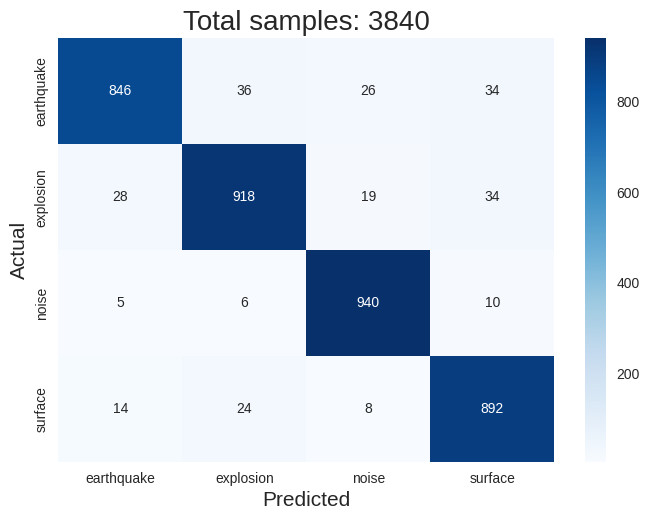

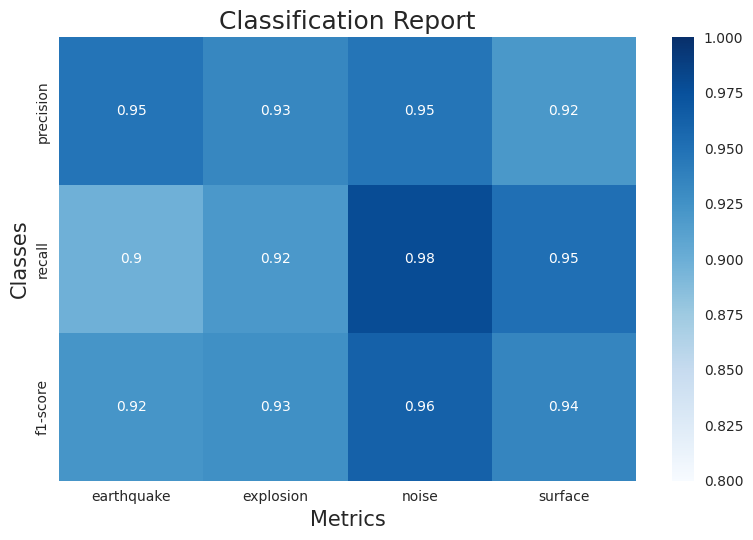

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1383.00it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:14<02:12,  1.47s/it]

[Epoch 10] loss: 0.379 - accuracy: 81.250


 20%|██        | 20/100 [00:29<01:56,  1.46s/it]

[Epoch 20] loss: 0.252 - accuracy: 89.844


 30%|███       | 30/100 [00:41<01:22,  1.18s/it]

[Epoch 30] loss: 0.174 - accuracy: 89.453


 40%|████      | 40/100 [00:53<01:09,  1.16s/it]

[Epoch 40] loss: 0.133 - accuracy: 92.188


 50%|█████     | 50/100 [01:04<00:57,  1.15s/it]

[Epoch 50] loss: 0.110 - accuracy: 92.188


 60%|██████    | 60/100 [01:16<00:44,  1.12s/it]

[Epoch 60] loss: 0.095 - accuracy: 91.016


 70%|███████   | 70/100 [01:27<00:33,  1.10s/it]

[Epoch 70] loss: 0.072 - accuracy: 92.188


 80%|████████  | 80/100 [01:38<00:22,  1.10s/it]

[Epoch 80] loss: 0.065 - accuracy: 92.578


 90%|█████████ | 90/100 [01:49<00:11,  1.10s/it]

[Epoch 90] loss: 0.062 - accuracy: 91.406


 92%|█████████▏| 92/100 [01:52<00:09,  1.22s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.220 and accuracy: 93.359
test loss: 0.223 and accuracy: 93.359


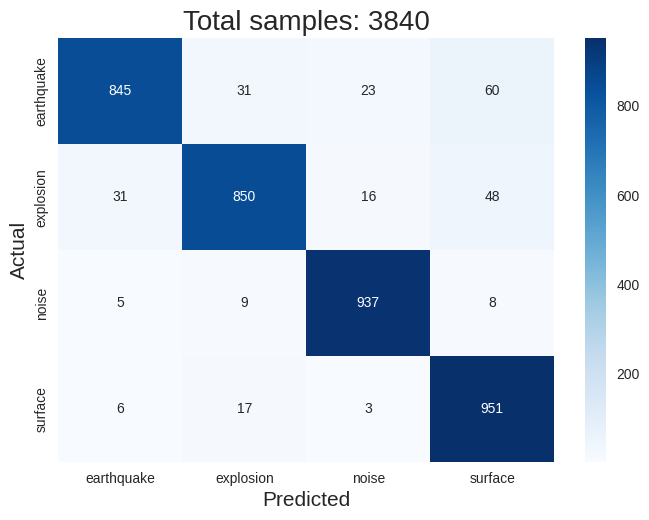

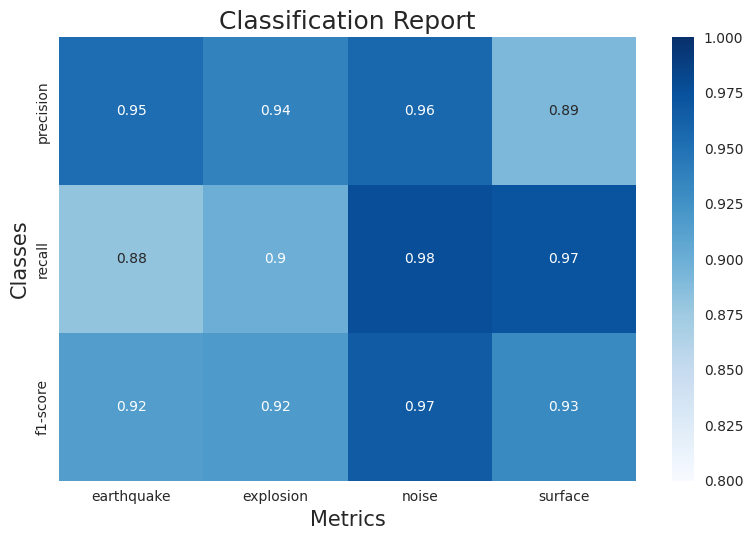

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1437.55it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:11<01:40,  1.12s/it]

[Epoch 10] loss: 0.357 - accuracy: 86.328


 20%|██        | 20/100 [00:22<01:29,  1.12s/it]

[Epoch 20] loss: 0.232 - accuracy: 91.406


 30%|███       | 30/100 [00:33<01:18,  1.12s/it]

[Epoch 30] loss: 0.157 - accuracy: 93.750


 40%|████      | 40/100 [00:44<01:06,  1.11s/it]

[Epoch 40] loss: 0.122 - accuracy: 94.922


 50%|█████     | 50/100 [00:55<00:55,  1.11s/it]

[Epoch 50] loss: 0.098 - accuracy: 94.141


 60%|██████    | 60/100 [01:06<00:44,  1.11s/it]

[Epoch 60] loss: 0.082 - accuracy: 94.141


 70%|███████   | 70/100 [01:18<00:33,  1.11s/it]

[Epoch 70] loss: 0.070 - accuracy: 93.750


 80%|████████  | 80/100 [01:29<00:22,  1.11s/it]

[Epoch 80] loss: 0.056 - accuracy: 95.312


 90%|█████████ | 90/100 [01:40<00:11,  1.12s/it]

[Epoch 90] loss: 0.054 - accuracy: 95.312


 91%|█████████ | 91/100 [01:42<00:10,  1.13s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.217 and accuracy: 93.620
test loss: 0.218 and accuracy: 93.516


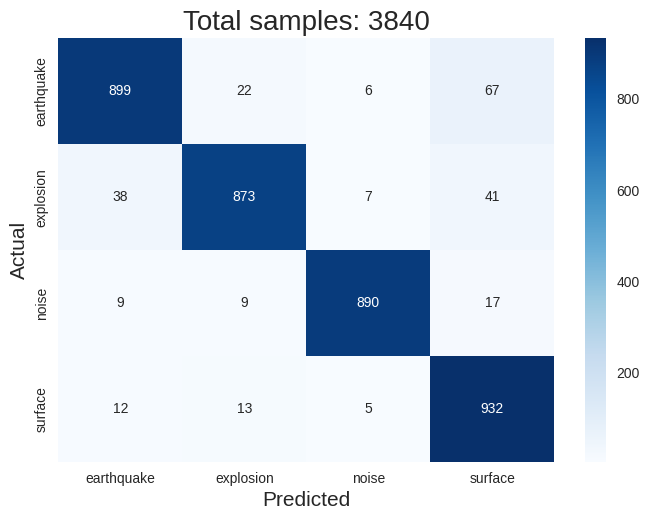

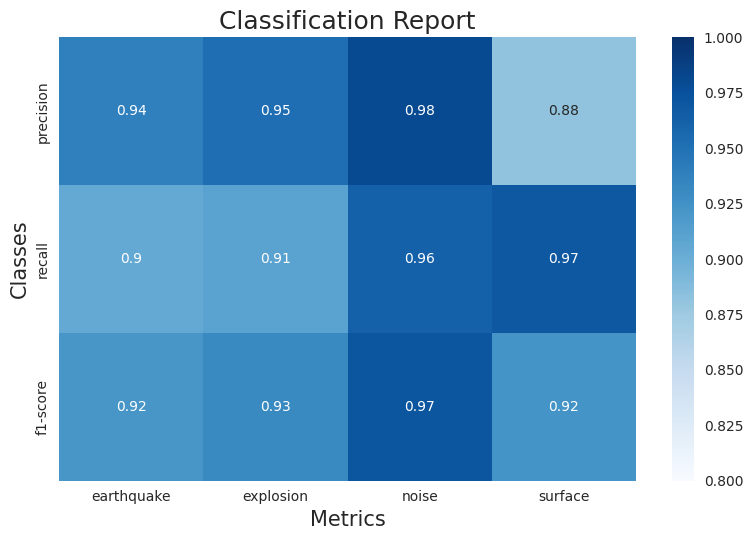

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1424.78it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:11<01:41,  1.13s/it]

[Epoch 10] loss: 0.362 - accuracy: 86.719


 20%|██        | 20/100 [00:22<01:30,  1.13s/it]

[Epoch 20] loss: 0.225 - accuracy: 89.844


 30%|███       | 30/100 [00:33<01:17,  1.11s/it]

[Epoch 30] loss: 0.158 - accuracy: 91.016


 40%|████      | 40/100 [00:44<01:06,  1.11s/it]

[Epoch 40] loss: 0.118 - accuracy: 90.625


 50%|█████     | 50/100 [00:56<00:55,  1.11s/it]

[Epoch 50] loss: 0.099 - accuracy: 92.578


 60%|██████    | 60/100 [01:07<00:44,  1.11s/it]

[Epoch 60] loss: 0.082 - accuracy: 92.969


 70%|███████   | 70/100 [01:18<00:33,  1.10s/it]

[Epoch 70] loss: 0.077 - accuracy: 94.141


 80%|████████  | 80/100 [01:29<00:22,  1.10s/it]

[Epoch 80] loss: 0.062 - accuracy: 92.969


 81%|████████  | 81/100 [01:31<00:21,  1.13s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.201 and accuracy: 94.271
test loss: 0.204 and accuracy: 94.219


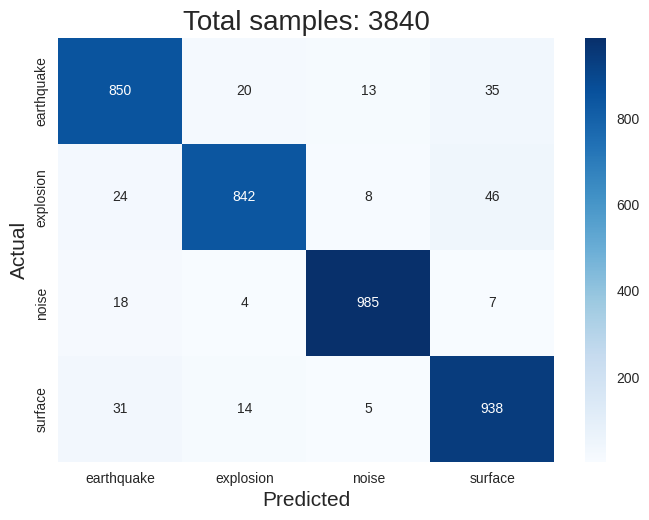

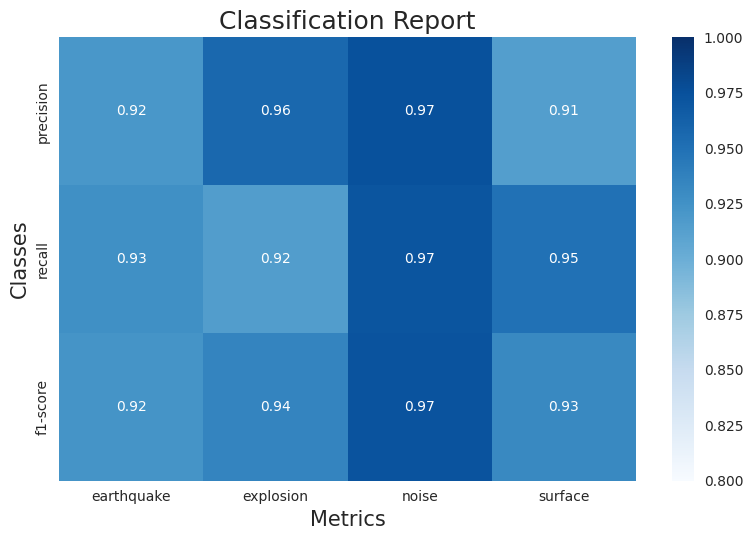

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1479.69it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:11<01:40,  1.12s/it]

[Epoch 10] loss: 0.367 - accuracy: 85.547


 20%|██        | 20/100 [00:22<01:28,  1.11s/it]

[Epoch 20] loss: 0.234 - accuracy: 89.062


 30%|███       | 30/100 [00:33<01:17,  1.10s/it]

[Epoch 30] loss: 0.171 - accuracy: 89.844


 40%|████      | 40/100 [00:44<01:05,  1.10s/it]

[Epoch 40] loss: 0.134 - accuracy: 91.016


 50%|█████     | 50/100 [00:55<00:55,  1.11s/it]

[Epoch 50] loss: 0.104 - accuracy: 92.188


 60%|██████    | 60/100 [01:06<00:44,  1.11s/it]

[Epoch 60] loss: 0.092 - accuracy: 93.359


 70%|███████   | 70/100 [01:17<00:33,  1.10s/it]

[Epoch 70] loss: 0.078 - accuracy: 92.969


 80%|████████  | 80/100 [01:28<00:22,  1.10s/it]

[Epoch 80] loss: 0.075 - accuracy: 91.406


 89%|████████▉ | 89/100 [01:39<00:12,  1.12s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.228 and accuracy: 93.568
test loss: 0.224 and accuracy: 93.620


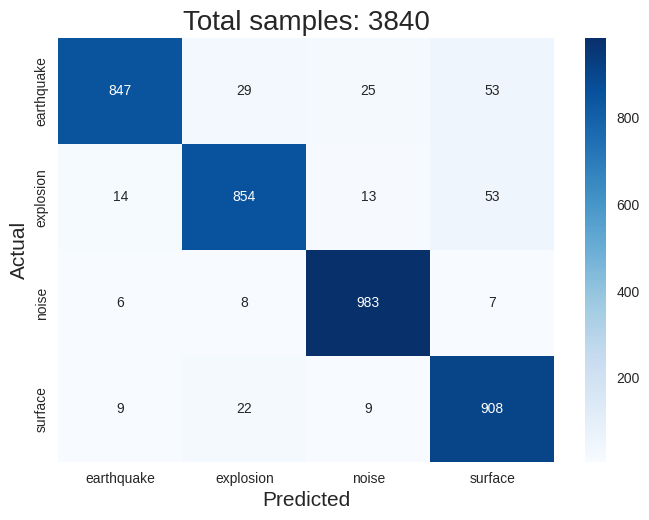

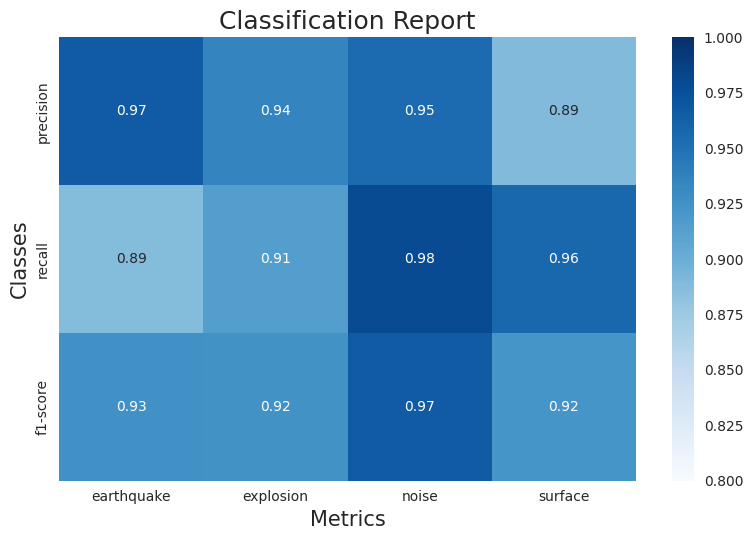

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1474.09it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:11<01:40,  1.11s/it]

[Epoch 10] loss: 0.365 - accuracy: 84.766


 20%|██        | 20/100 [00:22<01:28,  1.11s/it]

[Epoch 20] loss: 0.235 - accuracy: 88.281


 30%|███       | 30/100 [00:33<01:16,  1.10s/it]

[Epoch 30] loss: 0.166 - accuracy: 91.016


 40%|████      | 40/100 [00:44<01:06,  1.10s/it]

[Epoch 40] loss: 0.124 - accuracy: 89.844


 50%|█████     | 50/100 [00:55<00:54,  1.10s/it]

[Epoch 50] loss: 0.102 - accuracy: 92.578


 60%|██████    | 60/100 [01:06<00:43,  1.10s/it]

[Epoch 60] loss: 0.080 - accuracy: 94.141


 67%|██████▋   | 67/100 [01:14<00:36,  1.12s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.200 and accuracy: 93.568
test loss: 0.200 and accuracy: 93.542


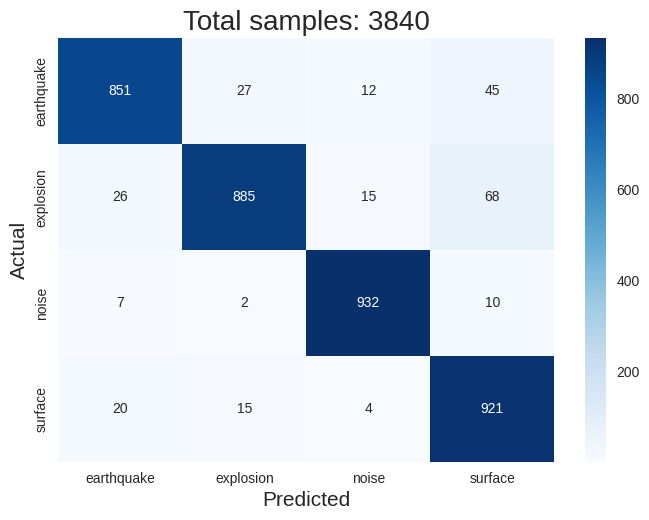

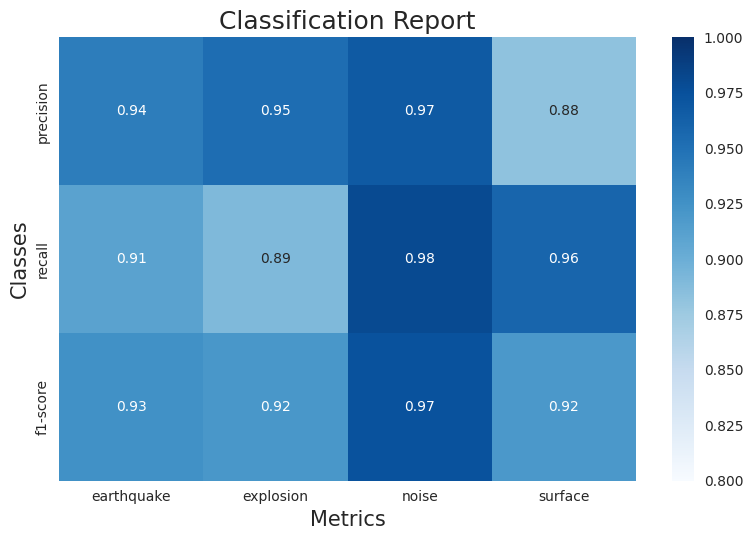

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1479.02it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:11<01:41,  1.12s/it]

[Epoch 10] loss: 0.364 - accuracy: 88.672


 20%|██        | 20/100 [00:22<01:29,  1.11s/it]

[Epoch 20] loss: 0.223 - accuracy: 91.797


 30%|███       | 30/100 [00:33<01:17,  1.10s/it]

[Epoch 30] loss: 0.169 - accuracy: 93.359


 40%|████      | 40/100 [00:44<01:06,  1.11s/it]

[Epoch 40] loss: 0.125 - accuracy: 93.750


 50%|█████     | 50/100 [00:55<00:55,  1.11s/it]

[Epoch 50] loss: 0.100 - accuracy: 94.141


 60%|██████    | 60/100 [01:06<00:44,  1.11s/it]

[Epoch 60] loss: 0.084 - accuracy: 94.531


 70%|███████   | 70/100 [01:17<00:33,  1.11s/it]

[Epoch 70] loss: 0.068 - accuracy: 94.922


 80%|████████  | 80/100 [01:28<00:22,  1.11s/it]

[Epoch 80] loss: 0.065 - accuracy: 94.531


 90%|█████████ | 90/100 [01:39<00:11,  1.11s/it]

[Epoch 90] loss: 0.057 - accuracy: 94.922


 98%|█████████▊| 98/100 [01:49<00:02,  1.12s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.212 and accuracy: 94.036
test loss: 0.214 and accuracy: 94.062


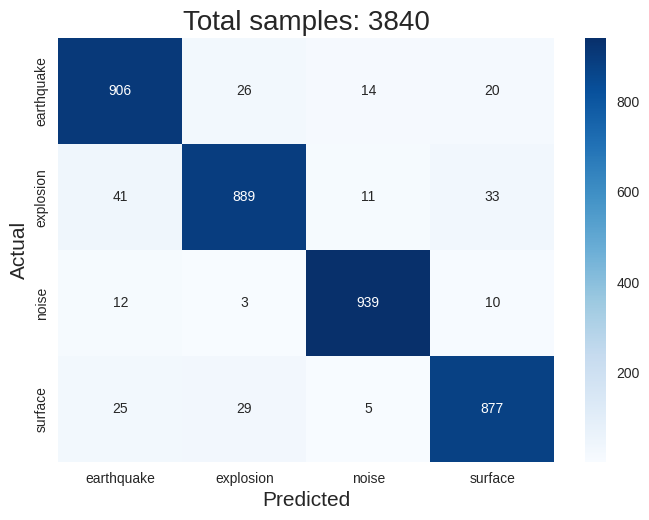

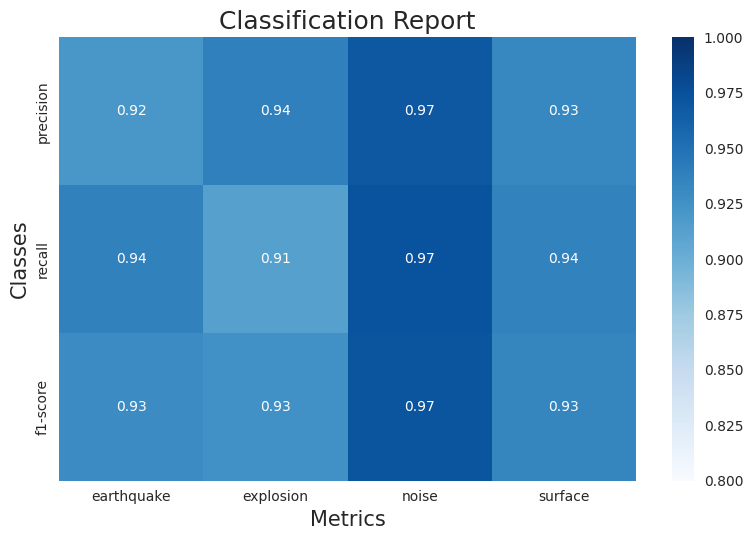

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1466.27it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:11<01:41,  1.12s/it]

[Epoch 10] loss: 0.368 - accuracy: 89.453


 20%|██        | 20/100 [00:22<01:29,  1.12s/it]

[Epoch 20] loss: 0.238 - accuracy: 92.578


 30%|███       | 30/100 [00:33<01:17,  1.11s/it]

[Epoch 30] loss: 0.165 - accuracy: 94.531


 40%|████      | 40/100 [00:44<01:06,  1.10s/it]

[Epoch 40] loss: 0.130 - accuracy: 92.969


 50%|█████     | 50/100 [00:55<00:55,  1.10s/it]

[Epoch 50] loss: 0.098 - accuracy: 95.703


 60%|██████    | 60/100 [01:06<00:44,  1.10s/it]

[Epoch 60] loss: 0.088 - accuracy: 94.531


 70%|███████   | 70/100 [01:17<00:32,  1.10s/it]

[Epoch 70] loss: 0.074 - accuracy: 95.312


 77%|███████▋  | 77/100 [01:26<00:25,  1.12s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.229 and accuracy: 93.516
test loss: 0.227 and accuracy: 93.568


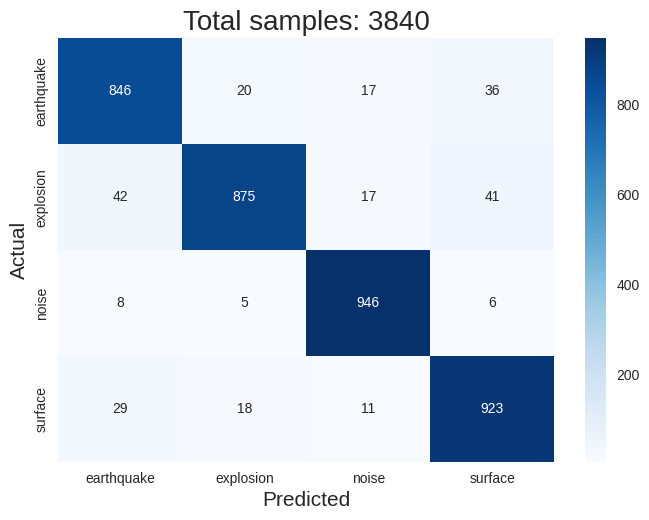

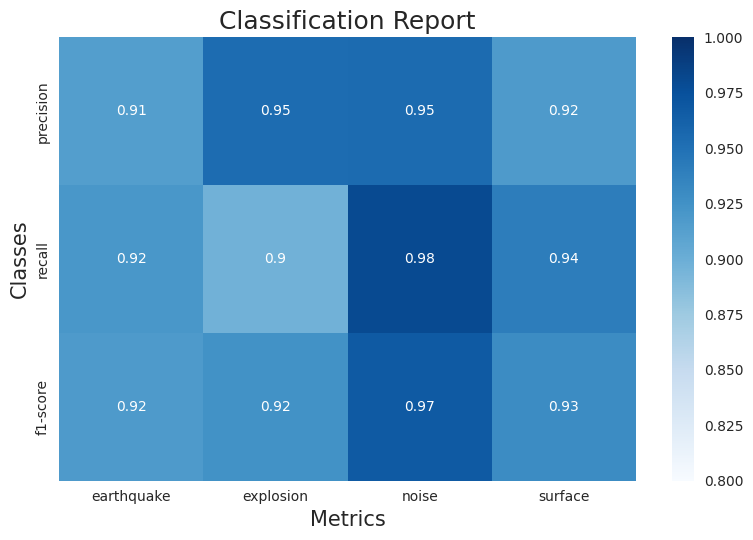

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1474.23it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:11<01:39,  1.10s/it]

[Epoch 10] loss: 0.369 - accuracy: 88.672


 20%|██        | 20/100 [00:22<01:28,  1.10s/it]

[Epoch 20] loss: 0.242 - accuracy: 92.578


 30%|███       | 30/100 [00:33<01:16,  1.10s/it]

[Epoch 30] loss: 0.175 - accuracy: 94.141


 40%|████      | 40/100 [00:44<01:05,  1.10s/it]

[Epoch 40] loss: 0.128 - accuracy: 94.141


 50%|█████     | 50/100 [00:55<00:54,  1.10s/it]

[Epoch 50] loss: 0.100 - accuracy: 94.922


 60%|██████    | 60/100 [01:05<00:43,  1.10s/it]

[Epoch 60] loss: 0.081 - accuracy: 95.312


 67%|██████▋   | 67/100 [01:14<00:36,  1.12s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.222 and accuracy: 93.021
test loss: 0.218 and accuracy: 93.125


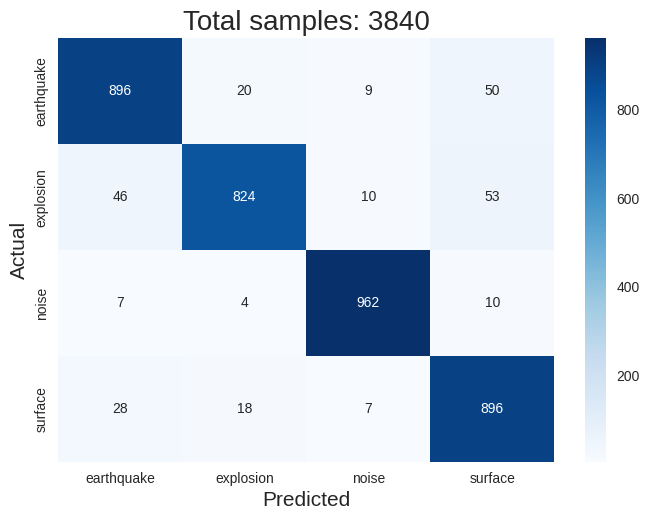

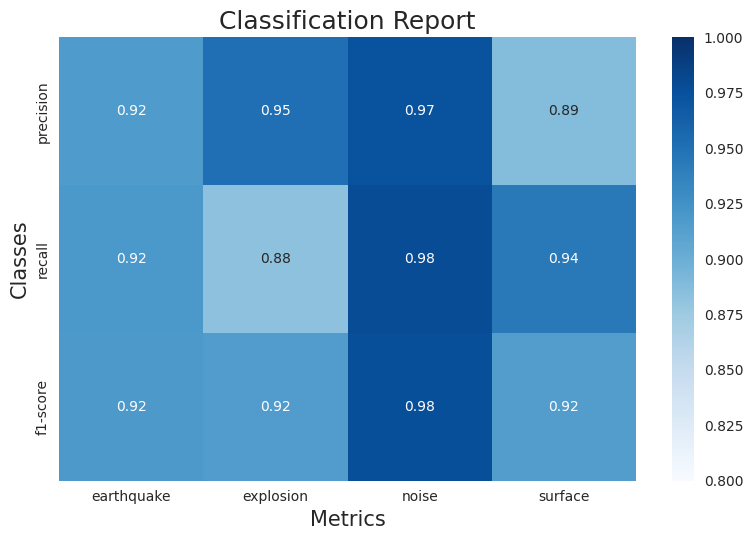

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1479.13it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:11<01:40,  1.11s/it]

[Epoch 10] loss: 0.360 - accuracy: 89.844


 20%|██        | 20/100 [00:22<01:28,  1.11s/it]

[Epoch 20] loss: 0.226 - accuracy: 88.281


 30%|███       | 30/100 [00:33<01:17,  1.10s/it]

[Epoch 30] loss: 0.164 - accuracy: 88.672


 40%|████      | 40/100 [00:44<01:06,  1.11s/it]

[Epoch 40] loss: 0.122 - accuracy: 92.188


 50%|█████     | 50/100 [00:55<00:55,  1.11s/it]

[Epoch 50] loss: 0.097 - accuracy: 94.141


 60%|██████    | 60/100 [01:06<00:43,  1.10s/it]

[Epoch 60] loss: 0.086 - accuracy: 92.578


 70%|███████   | 70/100 [01:17<00:32,  1.10s/it]

[Epoch 70] loss: 0.067 - accuracy: 94.531


 80%|████████  | 80/100 [01:28<00:21,  1.09s/it]

[Epoch 80] loss: 0.063 - accuracy: 92.188


 82%|████████▏ | 82/100 [01:31<00:20,  1.12s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.199 and accuracy: 93.880
test loss: 0.198 and accuracy: 93.854


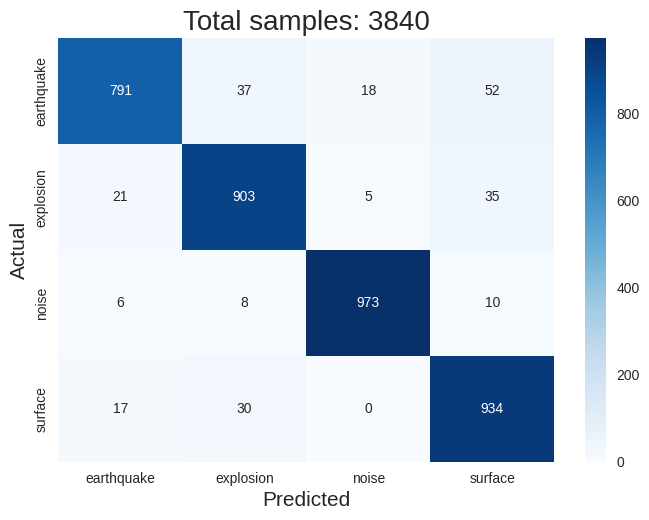

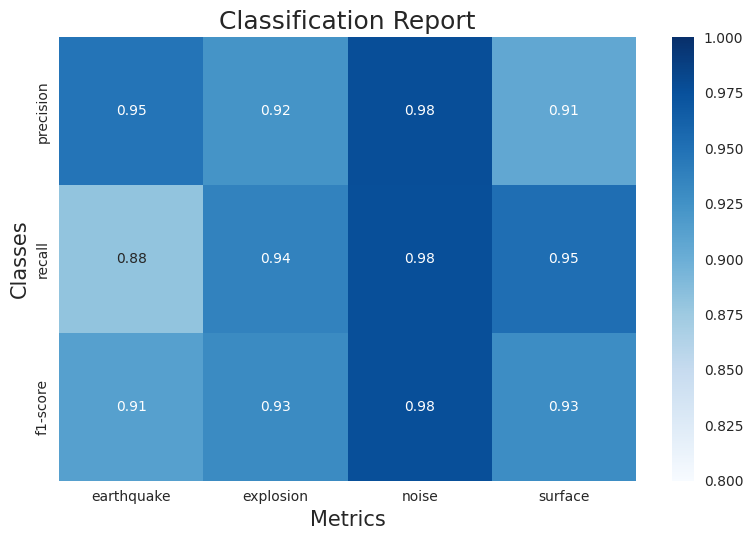

In [18]:
avg_cm_seismiccnn_2d = compute_average_model_performance(num_iter = 10, model_name = "model_seismiccnn_2d", one_d = False, d_su = d_su, d_eq = d_eq, d_exp = d_exp, d_noise = d_noise,
                                                         learning_rate = learning_rate, criterion = criterion)



  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1448.84it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:12<01:48,  1.20s/it]

[Epoch 10] loss: 0.337 - accuracy: 80.859


 20%|██        | 20/100 [00:24<01:36,  1.21s/it]

[Epoch 20] loss: 0.240 - accuracy: 89.844


 30%|███       | 30/100 [00:36<01:24,  1.21s/it]

[Epoch 30] loss: 0.191 - accuracy: 89.453


 40%|████      | 40/100 [00:48<01:11,  1.20s/it]

[Epoch 40] loss: 0.147 - accuracy: 90.234


 50%|█████     | 50/100 [01:00<00:59,  1.20s/it]

[Epoch 50] loss: 0.121 - accuracy: 91.406


 60%|██████    | 60/100 [01:12<00:47,  1.20s/it]

[Epoch 60] loss: 0.102 - accuracy: 89.844


 70%|███████   | 70/100 [01:24<00:35,  1.20s/it]

[Epoch 70] loss: 0.084 - accuracy: 90.234


 80%|████████  | 80/100 [01:36<00:23,  1.20s/it]

[Epoch 80] loss: 0.077 - accuracy: 92.578


 90%|█████████ | 90/100 [01:48<00:11,  1.19s/it]

[Epoch 90] loss: 0.061 - accuracy: 92.578


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]

[Epoch 100] loss: 0.049 - accuracy: 91.797



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('

test loss: 0.236 and accuracy: 92.552
test loss: 0.234 and accuracy: 92.500


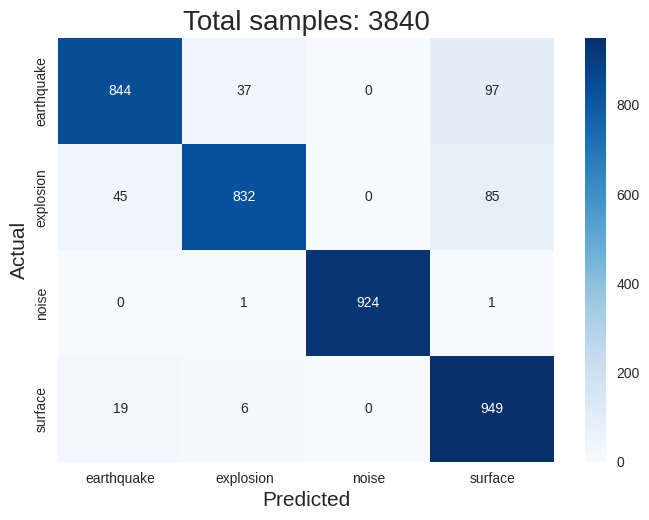

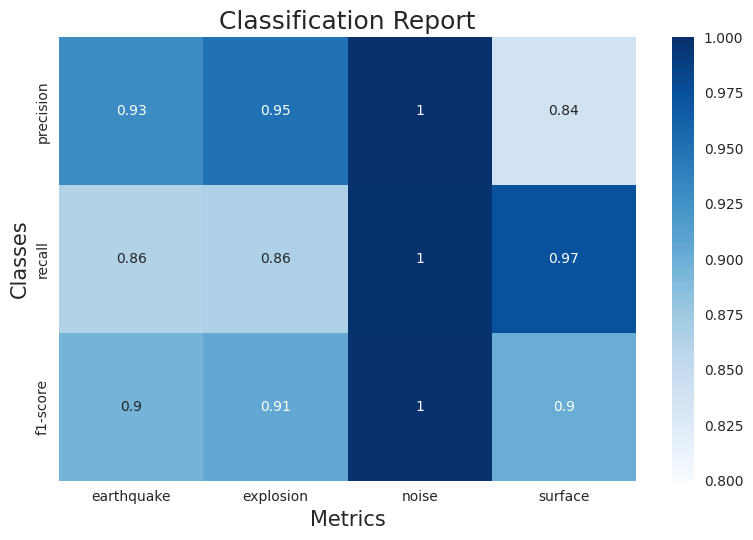

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1501.31it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:11<01:47,  1.20s/it]

[Epoch 10] loss: 0.357 - accuracy: 83.594


 20%|██        | 20/100 [00:23<01:35,  1.19s/it]

[Epoch 20] loss: 0.242 - accuracy: 91.406


 30%|███       | 30/100 [00:35<01:23,  1.20s/it]

[Epoch 30] loss: 0.184 - accuracy: 89.453


 40%|████      | 40/100 [00:47<01:11,  1.19s/it]

[Epoch 40] loss: 0.145 - accuracy: 92.578


 50%|█████     | 50/100 [00:59<00:59,  1.19s/it]

[Epoch 50] loss: 0.125 - accuracy: 92.578


 60%|██████    | 60/100 [01:11<00:47,  1.19s/it]

[Epoch 60] loss: 0.104 - accuracy: 93.750


 70%|███████   | 70/100 [01:23<00:35,  1.19s/it]

[Epoch 70] loss: 0.087 - accuracy: 89.844


 80%|████████  | 80/100 [01:35<00:23,  1.19s/it]

[Epoch 80] loss: 0.073 - accuracy: 92.969


 90%|█████████ | 90/100 [01:47<00:11,  1.19s/it]

[Epoch 90] loss: 0.063 - accuracy: 92.578


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]

[Epoch 100] loss: 0.054 - accuracy: 93.750



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('

test loss: 0.266 and accuracy: 91.250
test loss: 0.266 and accuracy: 91.224


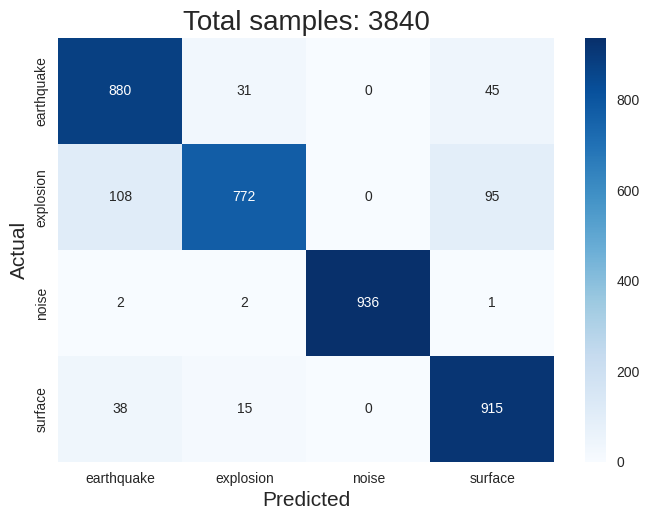

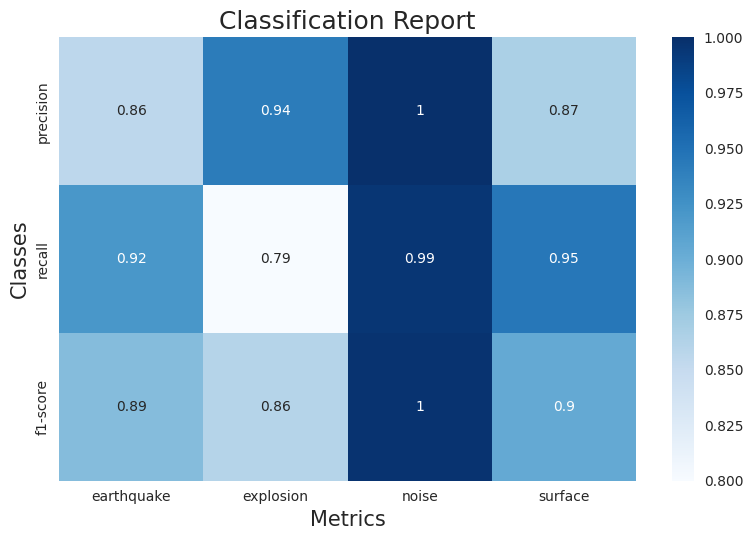

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1388.72it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:12<01:49,  1.21s/it]

[Epoch 10] loss: 0.348 - accuracy: 84.766


 20%|██        | 20/100 [00:24<01:36,  1.21s/it]

[Epoch 20] loss: 0.246 - accuracy: 89.844


 30%|███       | 30/100 [00:36<01:24,  1.21s/it]

[Epoch 30] loss: 0.191 - accuracy: 92.188


 40%|████      | 40/100 [00:48<01:12,  1.21s/it]

[Epoch 40] loss: 0.153 - accuracy: 91.406


 50%|█████     | 50/100 [01:00<01:00,  1.21s/it]

[Epoch 50] loss: 0.135 - accuracy: 90.234


 60%|██████    | 60/100 [01:12<00:48,  1.21s/it]

[Epoch 60] loss: 0.105 - accuracy: 92.188


 70%|███████   | 70/100 [01:24<00:36,  1.22s/it]

[Epoch 70] loss: 0.096 - accuracy: 90.625


 73%|███████▎  | 73/100 [01:29<00:33,  1.23s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.236 and accuracy: 91.745
test loss: 0.232 and accuracy: 91.901


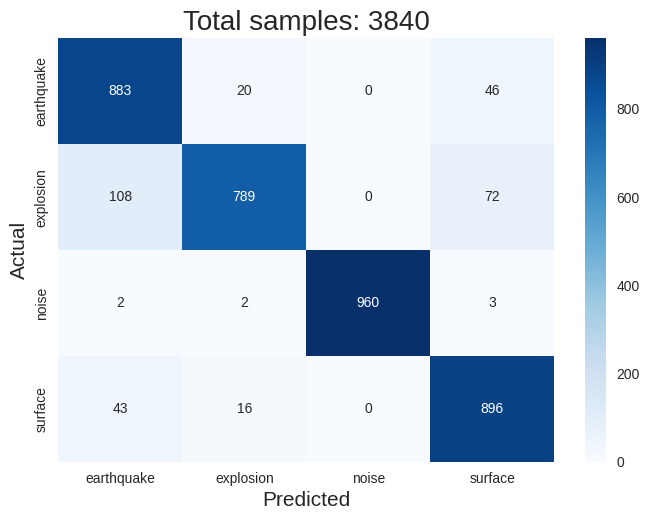

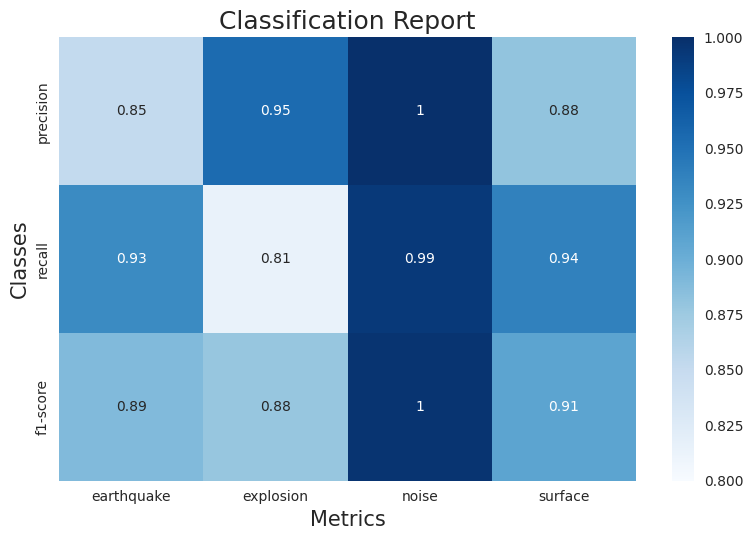

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1402.46it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:12<01:49,  1.22s/it]

[Epoch 10] loss: 0.348 - accuracy: 87.109


 20%|██        | 20/100 [00:24<01:36,  1.21s/it]

[Epoch 20] loss: 0.246 - accuracy: 85.156


 30%|███       | 30/100 [00:36<01:24,  1.21s/it]

[Epoch 30] loss: 0.194 - accuracy: 90.625


 40%|████      | 40/100 [00:48<01:12,  1.21s/it]

[Epoch 40] loss: 0.154 - accuracy: 88.281


 50%|█████     | 50/100 [01:00<01:00,  1.21s/it]

[Epoch 50] loss: 0.121 - accuracy: 88.281


 60%|██████    | 60/100 [01:12<00:48,  1.21s/it]

[Epoch 60] loss: 0.107 - accuracy: 89.844


 70%|███████   | 70/100 [01:24<00:36,  1.21s/it]

[Epoch 70] loss: 0.085 - accuracy: 87.891


 80%|████████  | 80/100 [01:36<00:24,  1.21s/it]

[Epoch 80] loss: 0.073 - accuracy: 87.891


 90%|█████████ | 90/100 [01:48<00:12,  1.21s/it]

[Epoch 90] loss: 0.068 - accuracy: 90.234


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]

[Epoch 100] loss: 0.053 - accuracy: 90.625



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('

test loss: 0.219 and accuracy: 92.839
test loss: 0.217 and accuracy: 92.786


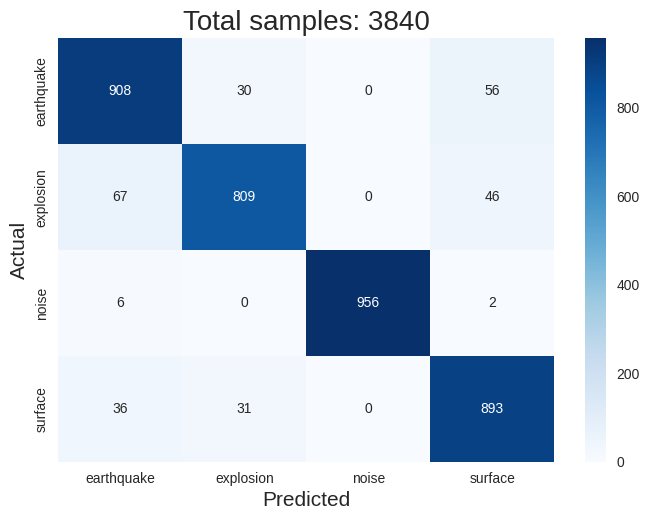

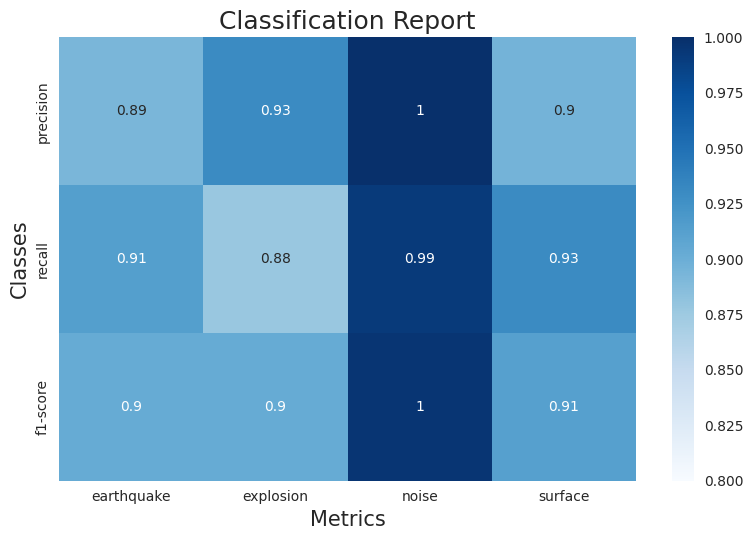

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1411.03it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:12<01:48,  1.21s/it]

[Epoch 10] loss: 0.342 - accuracy: 82.031


 20%|██        | 20/100 [00:24<01:36,  1.21s/it]

[Epoch 20] loss: 0.246 - accuracy: 93.750


 30%|███       | 30/100 [00:36<01:24,  1.20s/it]

[Epoch 30] loss: 0.191 - accuracy: 87.891


 40%|████      | 40/100 [00:48<01:12,  1.21s/it]

[Epoch 40] loss: 0.161 - accuracy: 92.578


 50%|█████     | 50/100 [01:00<01:00,  1.20s/it]

[Epoch 50] loss: 0.134 - accuracy: 86.328


 60%|██████    | 60/100 [01:12<00:48,  1.20s/it]

[Epoch 60] loss: 0.102 - accuracy: 95.312


 70%|███████   | 70/100 [01:24<00:36,  1.20s/it]

[Epoch 70] loss: 0.086 - accuracy: 90.625


 80%|████████  | 80/100 [01:36<00:24,  1.20s/it]

[Epoch 80] loss: 0.071 - accuracy: 90.234


 89%|████████▉ | 89/100 [01:48<00:13,  1.22s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.214 and accuracy: 92.943
test loss: 0.213 and accuracy: 92.943


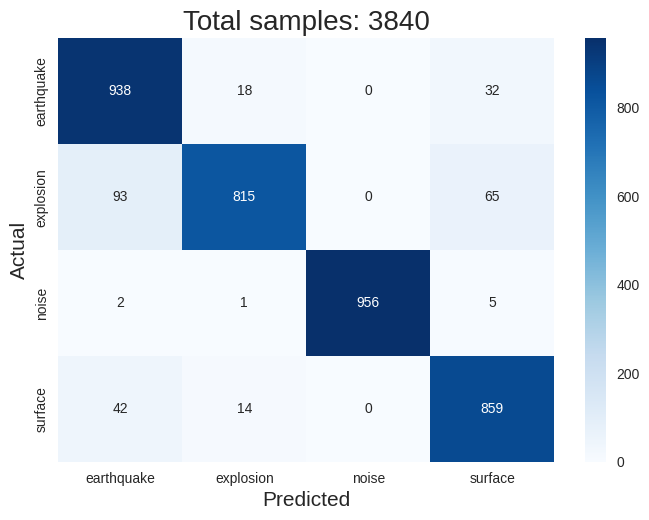

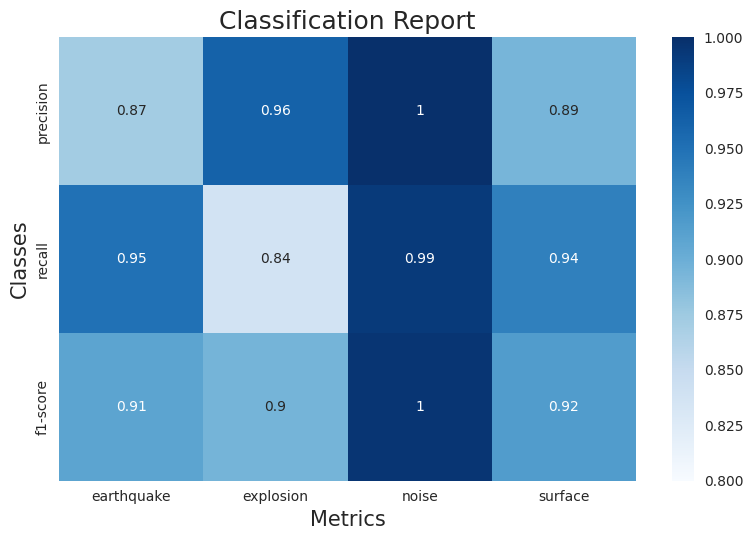

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1394.40it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:12<01:48,  1.21s/it]

[Epoch 10] loss: 0.339 - accuracy: 88.281


 20%|██        | 20/100 [00:24<01:36,  1.20s/it]

[Epoch 20] loss: 0.236 - accuracy: 91.016


 30%|███       | 30/100 [00:36<01:24,  1.20s/it]

[Epoch 30] loss: 0.183 - accuracy: 92.578


 40%|████      | 40/100 [00:48<01:12,  1.20s/it]

[Epoch 40] loss: 0.140 - accuracy: 95.312


 50%|█████     | 50/100 [01:00<01:00,  1.20s/it]

[Epoch 50] loss: 0.121 - accuracy: 93.750


 60%|██████    | 60/100 [01:12<00:48,  1.20s/it]

[Epoch 60] loss: 0.111 - accuracy: 91.797


 70%|███████   | 70/100 [01:24<00:36,  1.20s/it]

[Epoch 70] loss: 0.089 - accuracy: 92.578


 80%|████████  | 80/100 [01:36<00:24,  1.20s/it]

[Epoch 80] loss: 0.078 - accuracy: 91.797


 84%|████████▍ | 84/100 [01:42<00:19,  1.22s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.229 and accuracy: 92.734
test loss: 0.227 and accuracy: 92.839


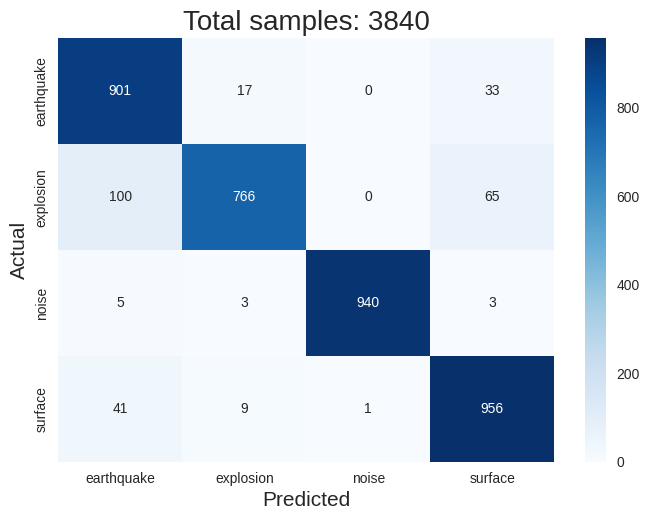

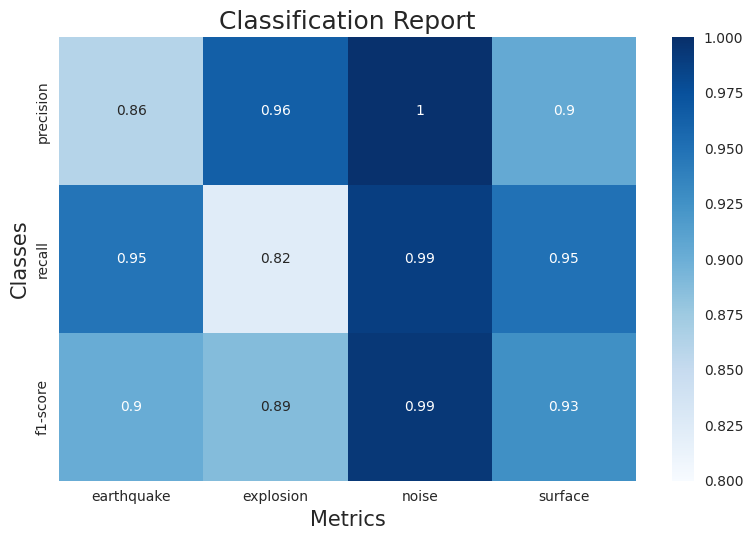

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1410.37it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:12<01:48,  1.21s/it]

[Epoch 10] loss: 0.342 - accuracy: 85.938


 20%|██        | 20/100 [00:24<01:36,  1.20s/it]

[Epoch 20] loss: 0.234 - accuracy: 92.188


 30%|███       | 30/100 [00:36<01:24,  1.20s/it]

[Epoch 30] loss: 0.190 - accuracy: 87.109


 40%|████      | 40/100 [00:48<01:11,  1.20s/it]

[Epoch 40] loss: 0.149 - accuracy: 88.281


 50%|█████     | 50/100 [01:00<00:59,  1.20s/it]

[Epoch 50] loss: 0.123 - accuracy: 91.016


 60%|██████    | 60/100 [01:12<00:47,  1.20s/it]

[Epoch 60] loss: 0.103 - accuracy: 90.625


 70%|███████   | 70/100 [01:24<00:35,  1.20s/it]

[Epoch 70] loss: 0.088 - accuracy: 91.406


 80%|████████  | 80/100 [01:35<00:23,  1.20s/it]

[Epoch 80] loss: 0.075 - accuracy: 89.062


 90%|█████████ | 90/100 [01:47<00:11,  1.20s/it]

[Epoch 90] loss: 0.061 - accuracy: 92.188


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]

[Epoch 100] loss: 0.055 - accuracy: 88.281



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('

test loss: 0.244 and accuracy: 92.292
test loss: 0.242 and accuracy: 92.318


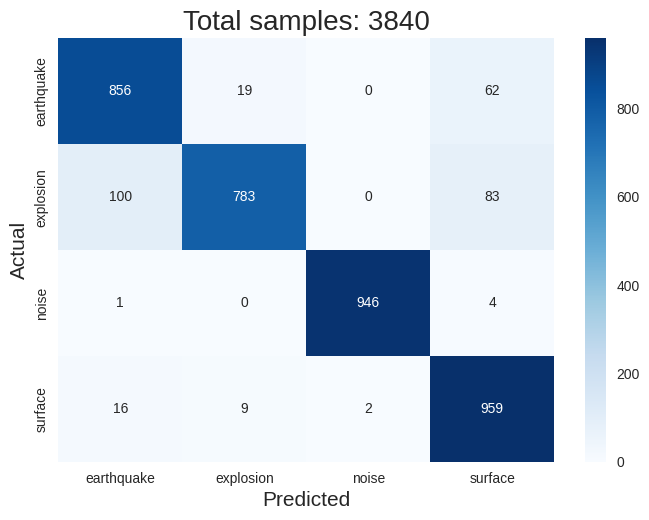

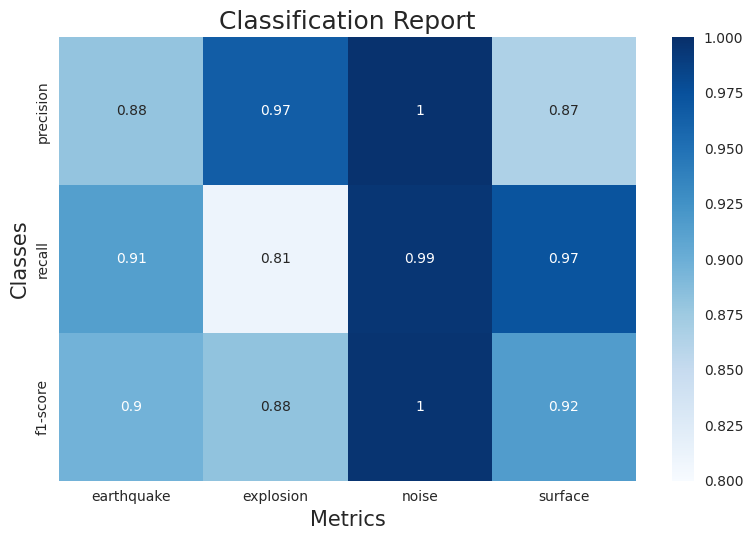

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1386.44it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:12<01:48,  1.21s/it]

[Epoch 10] loss: 0.344 - accuracy: 87.109


 20%|██        | 20/100 [00:24<01:36,  1.20s/it]

[Epoch 20] loss: 0.239 - accuracy: 90.234


 30%|███       | 30/100 [00:36<01:24,  1.20s/it]

[Epoch 30] loss: 0.189 - accuracy: 90.234


 40%|████      | 40/100 [00:48<01:11,  1.20s/it]

[Epoch 40] loss: 0.150 - accuracy: 91.797


 50%|█████     | 50/100 [01:00<00:59,  1.20s/it]

[Epoch 50] loss: 0.129 - accuracy: 91.406


 60%|██████    | 60/100 [01:12<00:48,  1.21s/it]

[Epoch 60] loss: 0.106 - accuracy: 93.359


 70%|███████   | 70/100 [01:24<00:36,  1.20s/it]

[Epoch 70] loss: 0.090 - accuracy: 93.750


 80%|████████  | 80/100 [01:36<00:24,  1.20s/it]

[Epoch 80] loss: 0.079 - accuracy: 93.359


 90%|█████████ | 90/100 [01:48<00:12,  1.20s/it]

[Epoch 90] loss: 0.068 - accuracy: 93.750


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]

[Epoch 100] loss: 0.056 - accuracy: 92.969



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('

test loss: 0.185 and accuracy: 93.672
test loss: 0.188 and accuracy: 93.542


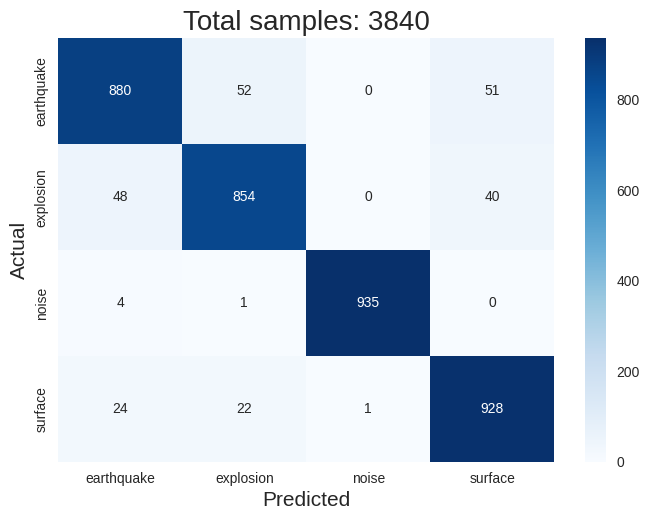

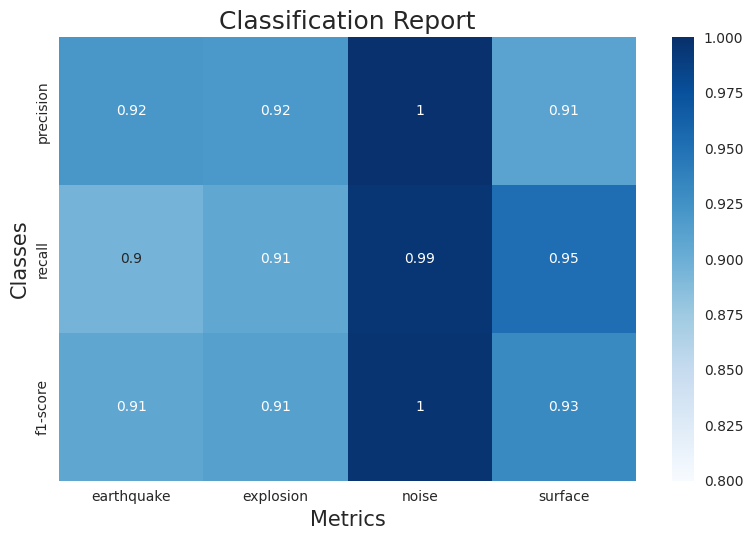

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1420.98it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:12<01:49,  1.21s/it]

[Epoch 10] loss: 0.351 - accuracy: 89.453


 20%|██        | 20/100 [00:24<01:36,  1.21s/it]

[Epoch 20] loss: 0.242 - accuracy: 90.234


 30%|███       | 30/100 [00:36<01:24,  1.21s/it]

[Epoch 30] loss: 0.199 - accuracy: 90.234


 40%|████      | 40/100 [00:48<01:12,  1.21s/it]

[Epoch 40] loss: 0.151 - accuracy: 93.359


 50%|█████     | 50/100 [01:00<01:00,  1.21s/it]

[Epoch 50] loss: 0.130 - accuracy: 90.625


 60%|██████    | 60/100 [01:12<00:48,  1.21s/it]

[Epoch 60] loss: 0.106 - accuracy: 91.797


 70%|███████   | 70/100 [01:24<00:36,  1.21s/it]

[Epoch 70] loss: 0.089 - accuracy: 94.531


 80%|████████  | 80/100 [01:36<00:24,  1.21s/it]

[Epoch 80] loss: 0.079 - accuracy: 91.016


 90%|█████████ | 90/100 [01:48<00:12,  1.21s/it]

[Epoch 90] loss: 0.067 - accuracy: 91.406


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]

[Epoch 100] loss: 0.057 - accuracy: 94.141



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('

test loss: 0.219 and accuracy: 92.839
test loss: 0.217 and accuracy: 92.917


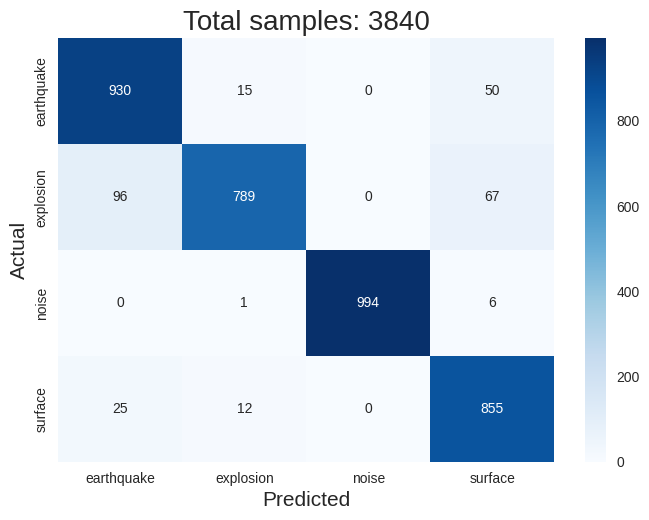

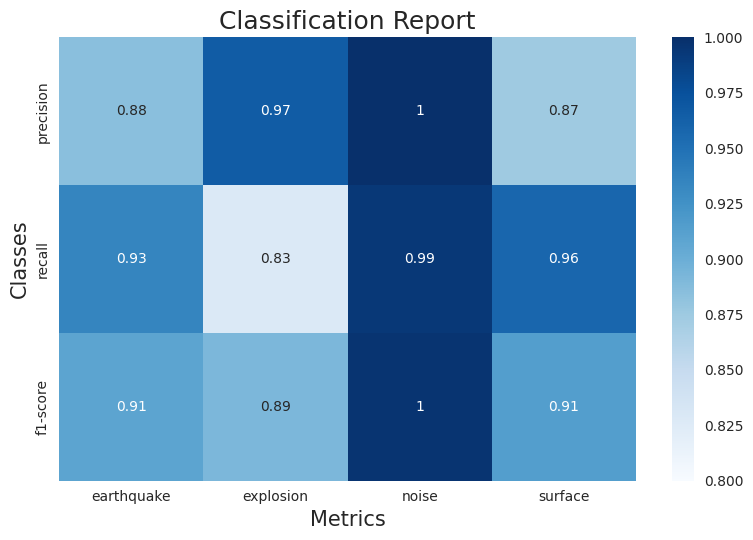

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1461.35it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:12<01:49,  1.21s/it]

[Epoch 10] loss: 0.343 - accuracy: 84.766


 20%|██        | 20/100 [00:24<01:36,  1.21s/it]

[Epoch 20] loss: 0.244 - accuracy: 89.062


 30%|███       | 30/100 [00:36<01:24,  1.21s/it]

[Epoch 30] loss: 0.185 - accuracy: 93.750


 40%|████      | 40/100 [00:48<01:12,  1.21s/it]

[Epoch 40] loss: 0.151 - accuracy: 92.578


 50%|█████     | 50/100 [01:00<01:00,  1.21s/it]

[Epoch 50] loss: 0.122 - accuracy: 93.359


 60%|██████    | 60/100 [01:12<00:48,  1.21s/it]

[Epoch 60] loss: 0.107 - accuracy: 92.969


 68%|██████▊   | 68/100 [01:23<00:39,  1.23s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.211 and accuracy: 92.370
test loss: 0.210 and accuracy: 92.474


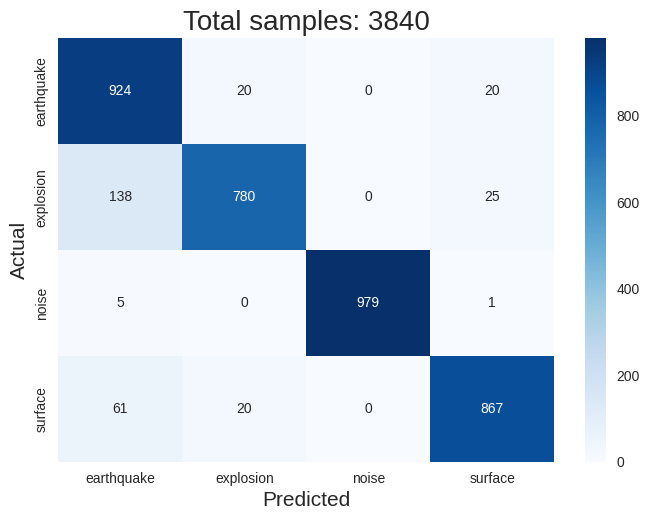

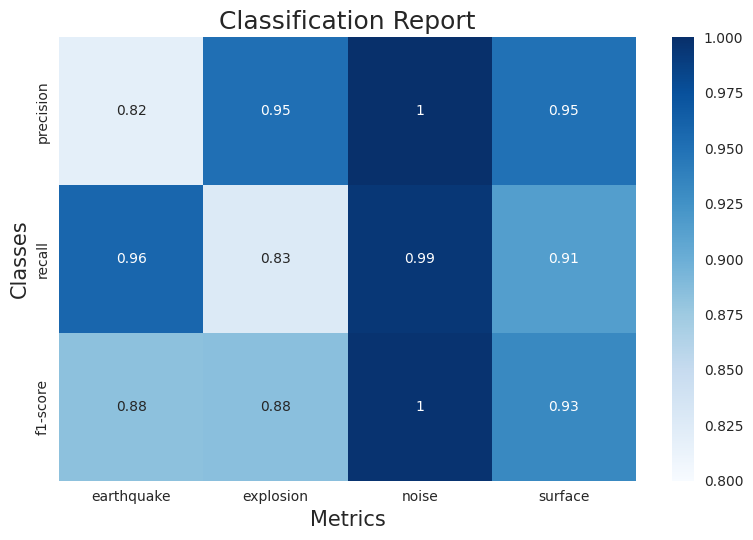

In [19]:
avg_cm_mycnn_1d = compute_average_model_performance(num_iter = 10, model_name = "model_mycnn_1d", one_d = True, d_su = d_su, d_eq = d_eq, d_exp = d_exp, d_noise = d_noise,
                                                         learning_rate = learning_rate, criterion = criterion)

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1457.82it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:36,  1.07s/it]

[Epoch 10] loss: 0.538 - accuracy: 84.375


 20%|██        | 20/100 [00:21<01:25,  1.07s/it]

[Epoch 20] loss: 0.437 - accuracy: 86.328


 30%|███       | 30/100 [00:32<01:14,  1.07s/it]

[Epoch 30] loss: 0.385 - accuracy: 89.453


 40%|████      | 40/100 [00:42<01:03,  1.07s/it]

[Epoch 40] loss: 0.353 - accuracy: 91.797


 50%|█████     | 50/100 [00:53<00:53,  1.06s/it]

[Epoch 50] loss: 0.335 - accuracy: 90.625


 60%|██████    | 60/100 [01:04<00:42,  1.06s/it]

[Epoch 60] loss: 0.312 - accuracy: 91.016


 70%|███████   | 70/100 [01:14<00:31,  1.07s/it]

[Epoch 70] loss: 0.305 - accuracy: 89.453


 80%|████████  | 80/100 [01:25<00:21,  1.07s/it]

[Epoch 80] loss: 0.303 - accuracy: 89.062


 81%|████████  | 81/100 [01:27<00:20,  1.08s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.298 and accuracy: 89.375
test loss: 0.296 and accuracy: 89.401


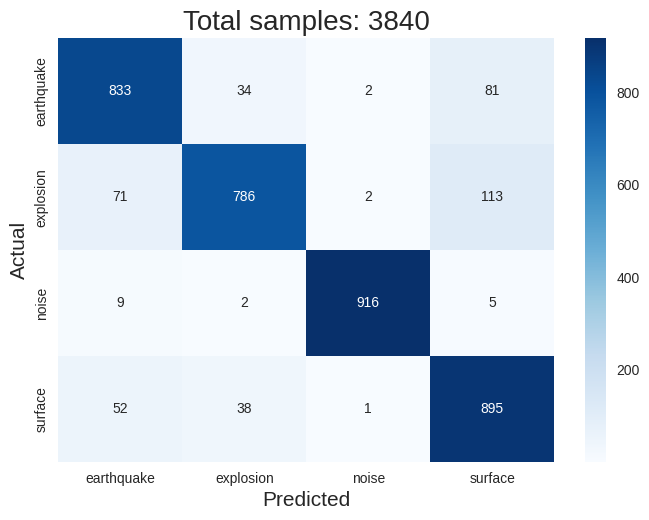

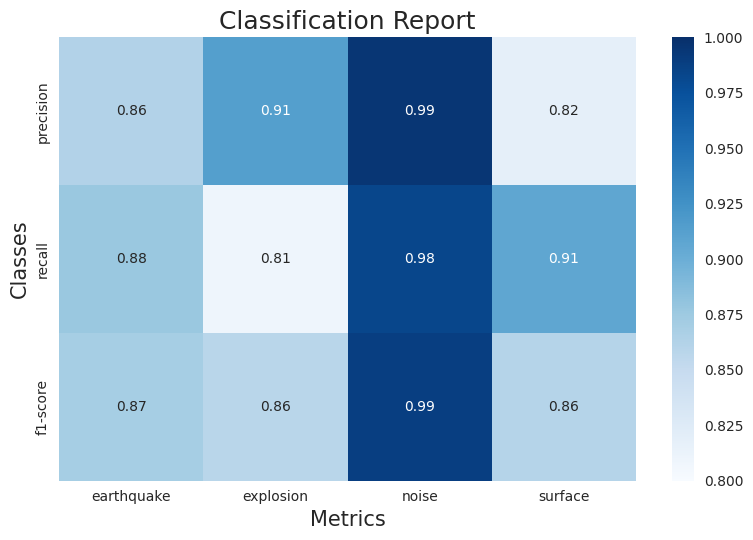

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1435.70it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:36,  1.07s/it]

[Epoch 10] loss: 0.558 - accuracy: 80.859


 20%|██        | 20/100 [00:21<01:25,  1.07s/it]

[Epoch 20] loss: 0.458 - accuracy: 85.938


 30%|███       | 30/100 [00:32<01:14,  1.07s/it]

[Epoch 30] loss: 0.400 - accuracy: 88.281


 40%|████      | 40/100 [00:42<01:03,  1.06s/it]

[Epoch 40] loss: 0.375 - accuracy: 88.281


 50%|█████     | 50/100 [00:53<00:53,  1.06s/it]

[Epoch 50] loss: 0.346 - accuracy: 90.234


 60%|██████    | 60/100 [01:03<00:42,  1.06s/it]

[Epoch 60] loss: 0.324 - accuracy: 92.578


 70%|███████   | 70/100 [01:14<00:31,  1.07s/it]

[Epoch 70] loss: 0.304 - accuracy: 92.578


 80%|████████  | 80/100 [01:25<00:21,  1.06s/it]

[Epoch 80] loss: 0.303 - accuracy: 93.359


 90%|█████████ | 90/100 [01:35<00:10,  1.07s/it]

[Epoch 90] loss: 0.292 - accuracy: 92.969


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]

[Epoch 100] loss: 0.295 - accuracy: 92.188



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

test loss: 0.286 and accuracy: 89.688
test loss: 0.284 and accuracy: 89.844


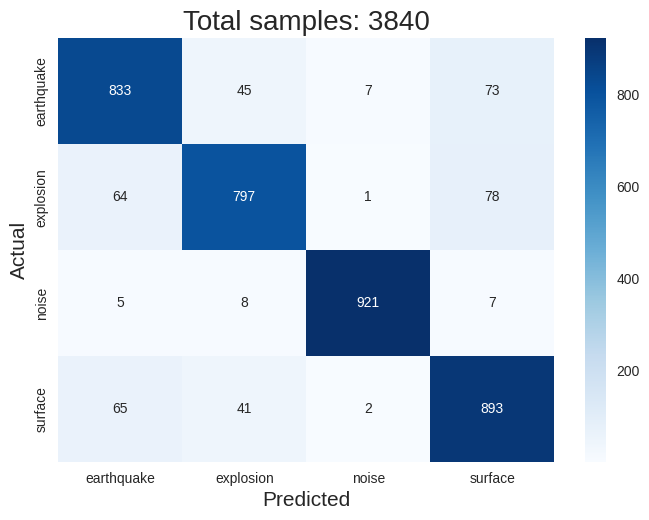

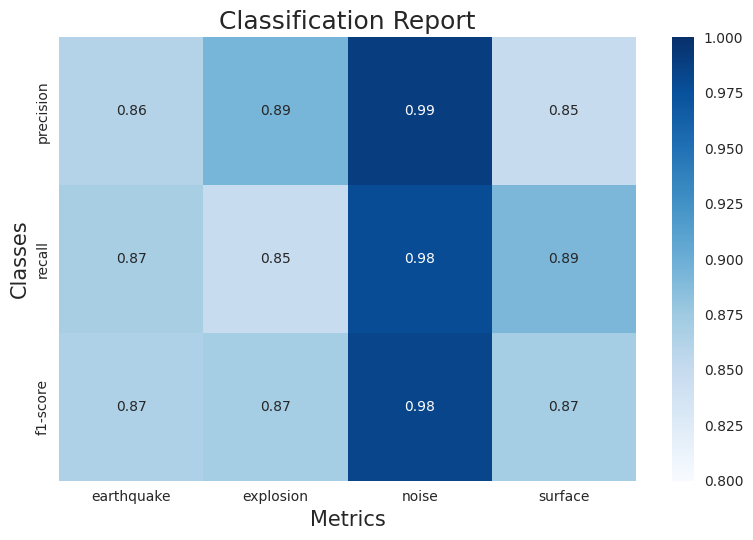

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1464.59it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:35,  1.07s/it]

[Epoch 10] loss: 0.585 - accuracy: 82.812


 20%|██        | 20/100 [00:21<01:25,  1.06s/it]

[Epoch 20] loss: 0.479 - accuracy: 86.719


 30%|███       | 30/100 [00:31<01:14,  1.06s/it]

[Epoch 30] loss: 0.421 - accuracy: 89.062


 40%|████      | 40/100 [00:42<01:03,  1.06s/it]

[Epoch 40] loss: 0.392 - accuracy: 88.281


 50%|█████     | 50/100 [00:53<00:53,  1.06s/it]

[Epoch 50] loss: 0.368 - accuracy: 89.062


 60%|██████    | 60/100 [01:03<00:42,  1.06s/it]

[Epoch 60] loss: 0.359 - accuracy: 91.016


 70%|███████   | 70/100 [01:14<00:31,  1.06s/it]

[Epoch 70] loss: 0.330 - accuracy: 89.844


 80%|████████  | 80/100 [01:25<00:21,  1.06s/it]

[Epoch 80] loss: 0.320 - accuracy: 91.016


 90%|█████████ | 90/100 [01:35<00:10,  1.07s/it]

[Epoch 90] loss: 0.324 - accuracy: 91.406


100%|██████████| 100/100 [01:46<00:00,  1.06s/it]

[Epoch 100] loss: 0.308 - accuracy: 91.406



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

test loss: 0.248 and accuracy: 91.432
test loss: 0.249 and accuracy: 91.380


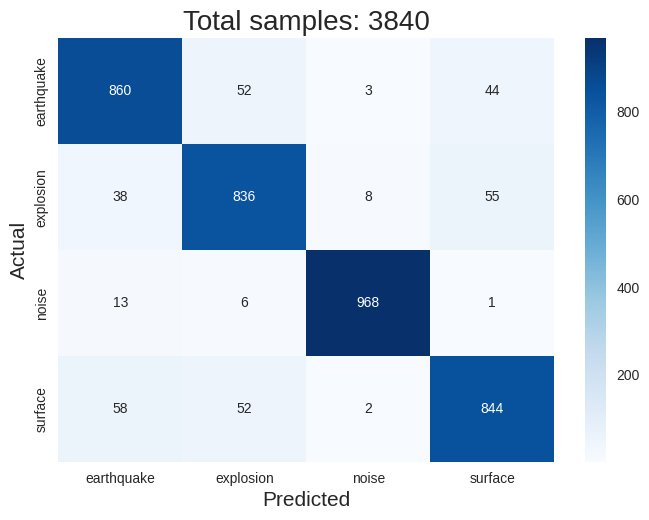

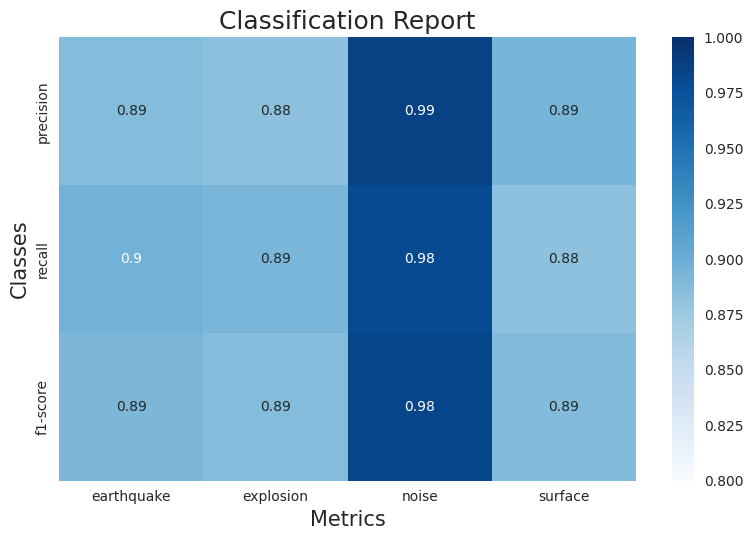

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1433.61it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:35,  1.07s/it]

[Epoch 10] loss: 0.578 - accuracy: 79.297


 20%|██        | 20/100 [00:21<01:25,  1.06s/it]

[Epoch 20] loss: 0.464 - accuracy: 85.547


 30%|███       | 30/100 [00:31<01:14,  1.06s/it]

[Epoch 30] loss: 0.407 - accuracy: 87.109


 40%|████      | 40/100 [00:42<01:03,  1.07s/it]

[Epoch 40] loss: 0.379 - accuracy: 88.672


 50%|█████     | 50/100 [00:53<00:53,  1.07s/it]

[Epoch 50] loss: 0.354 - accuracy: 90.625


 60%|██████    | 60/100 [01:03<00:42,  1.06s/it]

[Epoch 60] loss: 0.334 - accuracy: 88.281


 70%|███████   | 70/100 [01:14<00:31,  1.06s/it]

[Epoch 70] loss: 0.321 - accuracy: 88.281


 80%|████████  | 80/100 [01:25<00:21,  1.06s/it]

[Epoch 80] loss: 0.317 - accuracy: 89.844


 83%|████████▎ | 83/100 [01:29<00:18,  1.08s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.306 and accuracy: 89.844
test loss: 0.307 and accuracy: 89.818


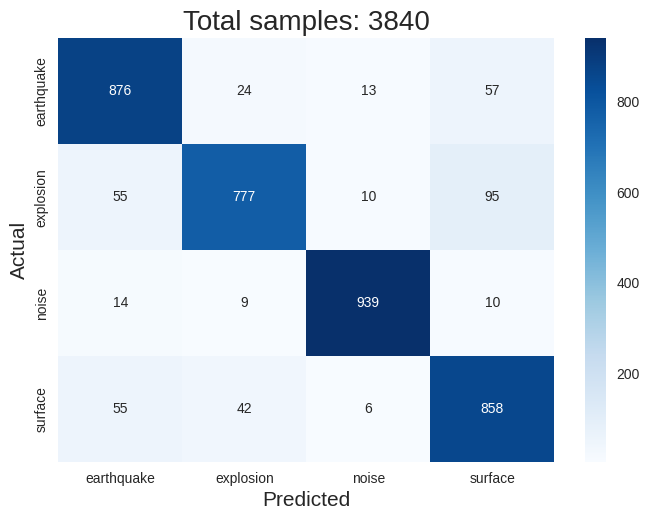

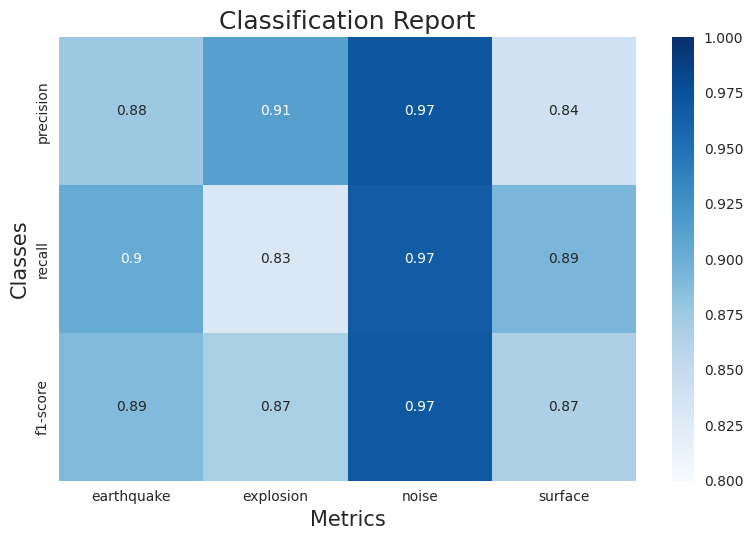

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1456.88it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:36,  1.07s/it]

[Epoch 10] loss: 0.566 - accuracy: 82.422


 20%|██        | 20/100 [00:21<01:25,  1.07s/it]

[Epoch 20] loss: 0.477 - accuracy: 85.547


 30%|███       | 30/100 [00:31<01:14,  1.07s/it]

[Epoch 30] loss: 0.419 - accuracy: 87.109


 40%|████      | 40/100 [00:42<01:03,  1.06s/it]

[Epoch 40] loss: 0.382 - accuracy: 87.891


 50%|█████     | 50/100 [00:53<00:53,  1.07s/it]

[Epoch 50] loss: 0.353 - accuracy: 91.016


 60%|██████    | 60/100 [01:03<00:42,  1.06s/it]

[Epoch 60] loss: 0.343 - accuracy: 92.188


 70%|███████   | 70/100 [01:14<00:31,  1.07s/it]

[Epoch 70] loss: 0.323 - accuracy: 92.578


 80%|████████  | 80/100 [01:25<00:21,  1.06s/it]

[Epoch 80] loss: 0.312 - accuracy: 92.188


 90%|█████████ | 90/100 [01:35<00:10,  1.06s/it]

[Epoch 90] loss: 0.301 - accuracy: 92.969


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]

[Epoch 100] loss: 0.294 - accuracy: 91.797



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

test loss: 0.289 and accuracy: 89.896
test loss: 0.286 and accuracy: 89.974


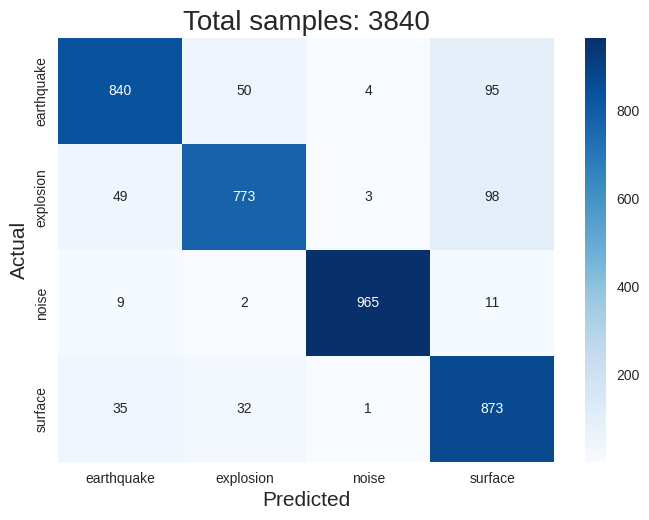

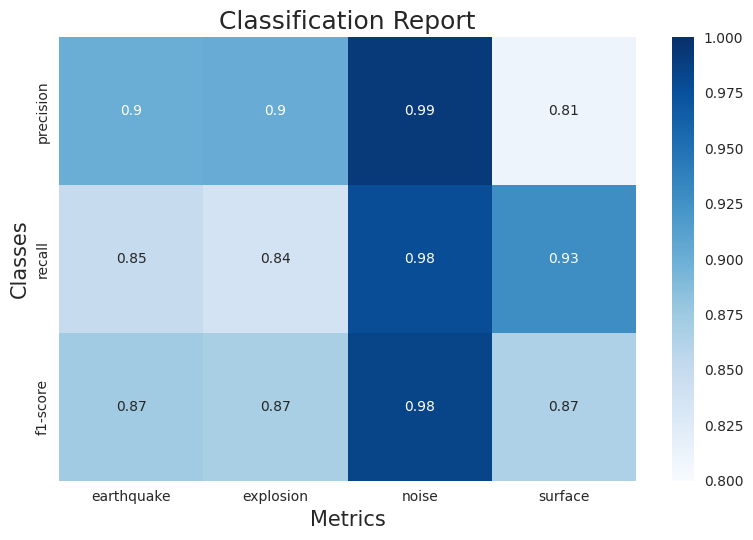

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1475.44it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:36,  1.07s/it]

[Epoch 10] loss: 0.555 - accuracy: 81.250


 20%|██        | 20/100 [00:21<01:25,  1.07s/it]

[Epoch 20] loss: 0.452 - accuracy: 85.156


 30%|███       | 30/100 [00:32<01:14,  1.07s/it]

[Epoch 30] loss: 0.407 - accuracy: 87.500


 40%|████      | 40/100 [00:42<01:03,  1.06s/it]

[Epoch 40] loss: 0.373 - accuracy: 87.500


 50%|█████     | 50/100 [00:53<00:53,  1.06s/it]

[Epoch 50] loss: 0.354 - accuracy: 90.234


 60%|██████    | 60/100 [01:03<00:42,  1.06s/it]

[Epoch 60] loss: 0.339 - accuracy: 89.844


 70%|███████   | 70/100 [01:14<00:31,  1.06s/it]

[Epoch 70] loss: 0.314 - accuracy: 91.016


 80%|████████  | 80/100 [01:25<00:21,  1.07s/it]

[Epoch 80] loss: 0.319 - accuracy: 89.844


 90%|█████████ | 90/100 [01:35<00:10,  1.07s/it]

[Epoch 90] loss: 0.302 - accuracy: 91.406


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]

[Epoch 100] loss: 0.295 - accuracy: 90.625



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

test loss: 0.261 and accuracy: 90.885
test loss: 0.264 and accuracy: 90.885


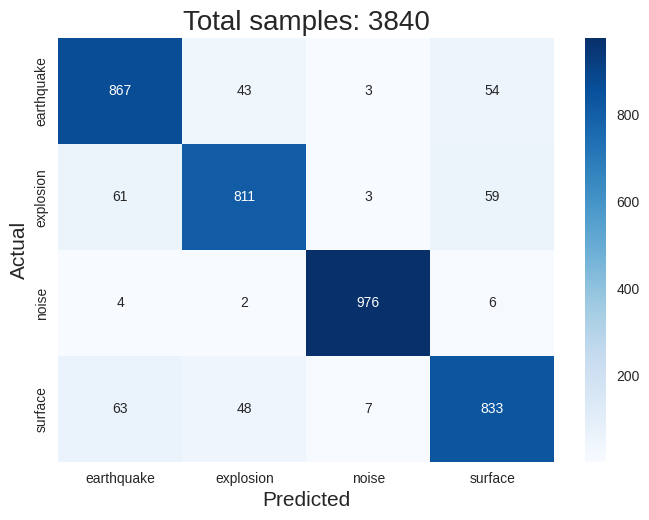

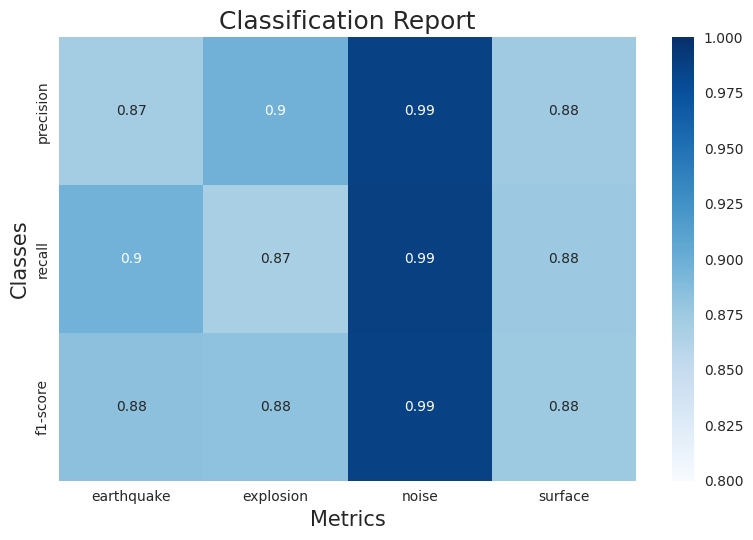

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1401.93it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:38,  1.09s/it]

[Epoch 10] loss: 0.584 - accuracy: 84.766


 20%|██        | 20/100 [00:21<01:27,  1.09s/it]

[Epoch 20] loss: 0.466 - accuracy: 87.891


 30%|███       | 30/100 [00:32<01:15,  1.08s/it]

[Epoch 30] loss: 0.419 - accuracy: 89.062


 40%|████      | 40/100 [00:43<01:04,  1.08s/it]

[Epoch 40] loss: 0.380 - accuracy: 91.016


 50%|█████     | 50/100 [00:54<00:54,  1.08s/it]

[Epoch 50] loss: 0.363 - accuracy: 90.234


 60%|██████    | 60/100 [01:05<00:43,  1.08s/it]

[Epoch 60] loss: 0.350 - accuracy: 86.719


 70%|███████   | 70/100 [01:15<00:32,  1.08s/it]

[Epoch 70] loss: 0.336 - accuracy: 86.328


 80%|████████  | 80/100 [01:26<00:21,  1.08s/it]

[Epoch 80] loss: 0.312 - accuracy: 89.844


 90%|█████████ | 90/100 [01:37<00:10,  1.08s/it]

[Epoch 90] loss: 0.316 - accuracy: 87.891


100%|██████████| 100/100 [01:48<00:00,  1.08s/it]

[Epoch 100] loss: 0.308 - accuracy: 90.625



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

test loss: 0.267 and accuracy: 90.625
test loss: 0.271 and accuracy: 90.495


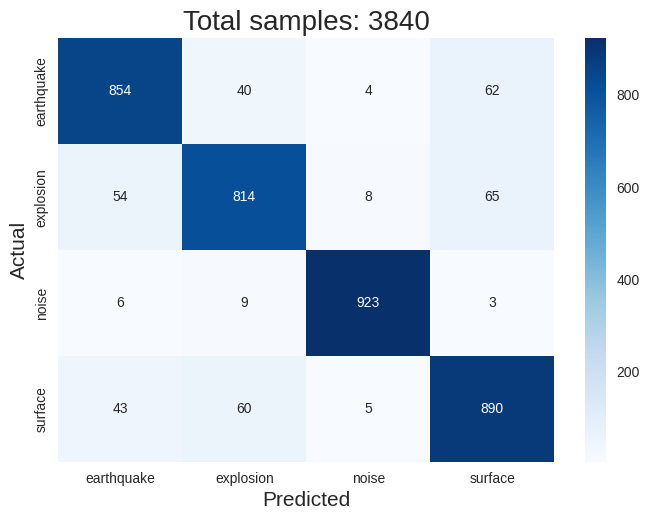

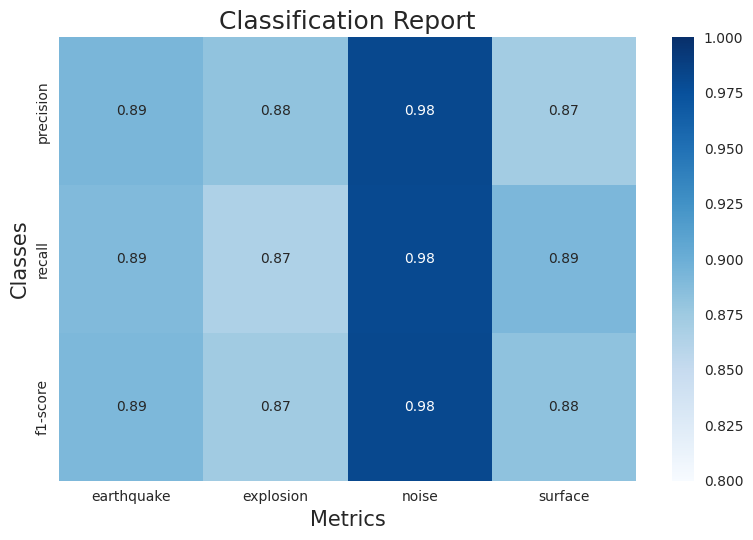

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1465.68it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:37,  1.08s/it]

[Epoch 10] loss: 0.556 - accuracy: 84.766


 20%|██        | 20/100 [00:21<01:26,  1.08s/it]

[Epoch 20] loss: 0.432 - accuracy: 87.500


 30%|███       | 30/100 [00:32<01:15,  1.07s/it]

[Epoch 30] loss: 0.390 - accuracy: 90.234


 40%|████      | 40/100 [00:43<01:04,  1.07s/it]

[Epoch 40] loss: 0.350 - accuracy: 91.406


 50%|█████     | 50/100 [00:53<00:53,  1.07s/it]

[Epoch 50] loss: 0.330 - accuracy: 89.844


 60%|██████    | 60/100 [01:04<00:42,  1.07s/it]

[Epoch 60] loss: 0.312 - accuracy: 91.016


 70%|███████   | 70/100 [01:15<00:32,  1.07s/it]

[Epoch 70] loss: 0.300 - accuracy: 91.797


 80%|████████  | 80/100 [01:25<00:21,  1.07s/it]

[Epoch 80] loss: 0.298 - accuracy: 92.969


 90%|█████████ | 90/100 [01:36<00:10,  1.07s/it]

[Epoch 90] loss: 0.292 - accuracy: 91.016


100%|██████████| 100/100 [01:47<00:00,  1.07s/it]

[Epoch 100] loss: 0.273 - accuracy: 93.359



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

test loss: 0.241 and accuracy: 92.422
test loss: 0.245 and accuracy: 92.318


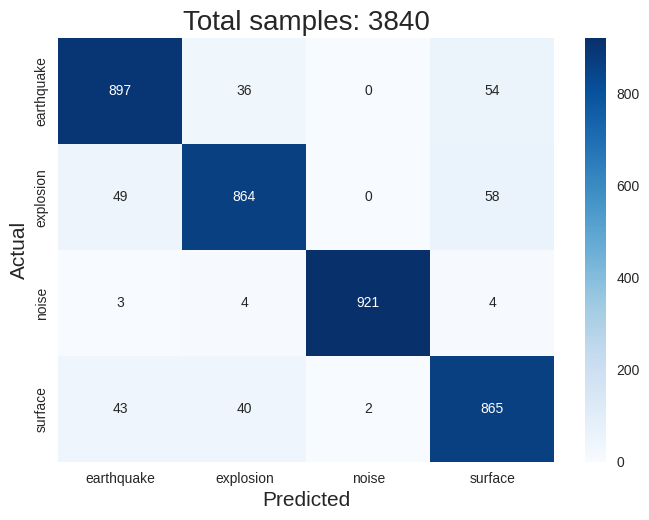

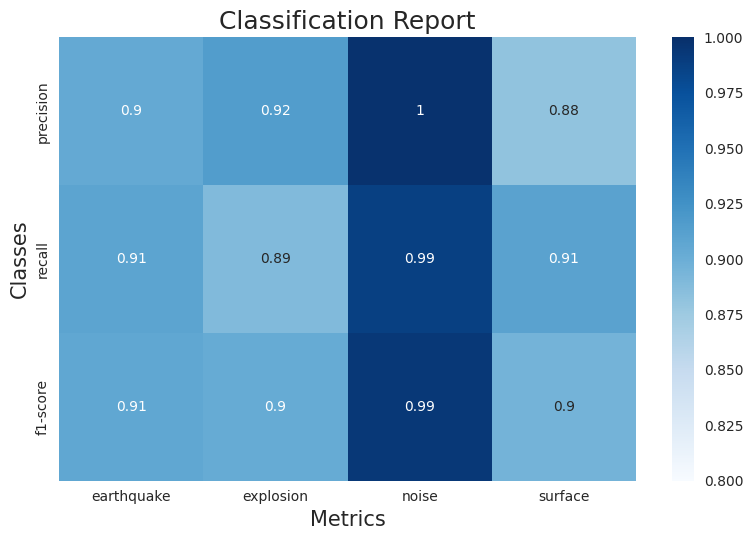

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1535.28it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:09<01:27,  1.03it/s]

[Epoch 10] loss: 0.566 - accuracy: 83.594


 20%|██        | 20/100 [00:20<01:25,  1.06s/it]

[Epoch 20] loss: 0.466 - accuracy: 87.891


 30%|███       | 30/100 [00:30<01:14,  1.07s/it]

[Epoch 30] loss: 0.417 - accuracy: 88.281


 40%|████      | 40/100 [00:41<01:04,  1.07s/it]

[Epoch 40] loss: 0.391 - accuracy: 89.844


 50%|█████     | 50/100 [00:52<00:53,  1.07s/it]

[Epoch 50] loss: 0.357 - accuracy: 89.844


 60%|██████    | 60/100 [01:02<00:43,  1.08s/it]

[Epoch 60] loss: 0.345 - accuracy: 88.672


 70%|███████   | 70/100 [01:13<00:32,  1.08s/it]

[Epoch 70] loss: 0.332 - accuracy: 92.578


 80%|████████  | 80/100 [01:24<00:21,  1.08s/it]

[Epoch 80] loss: 0.324 - accuracy: 91.406


 90%|█████████ | 90/100 [01:35<00:10,  1.08s/it]

[Epoch 90] loss: 0.305 - accuracy: 91.406


100%|██████████| 100/100 [01:46<00:00,  1.06s/it]

[Epoch 100] loss: 0.311 - accuracy: 92.578



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

test loss: 0.267 and accuracy: 90.911
test loss: 0.270 and accuracy: 90.781


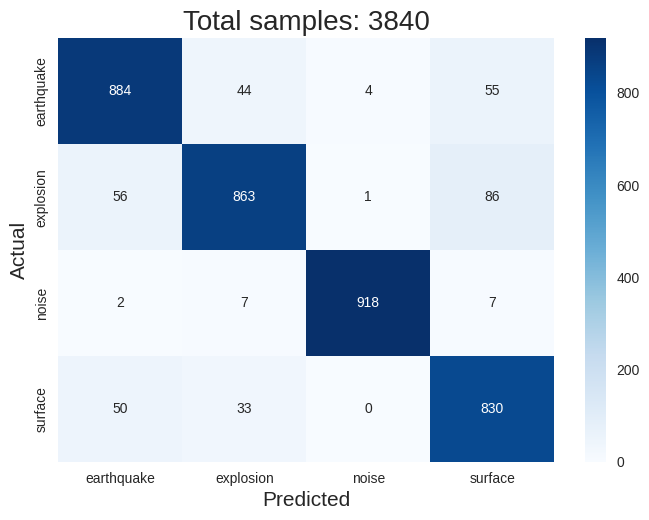

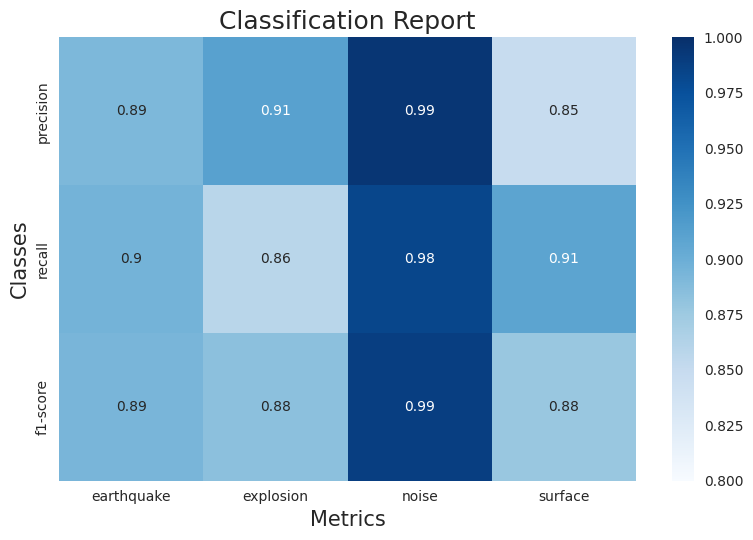

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1454.88it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:36,  1.07s/it]

[Epoch 10] loss: 0.582 - accuracy: 78.516


 20%|██        | 20/100 [00:21<01:25,  1.07s/it]

[Epoch 20] loss: 0.467 - accuracy: 85.938


 30%|███       | 30/100 [00:32<01:14,  1.07s/it]

[Epoch 30] loss: 0.413 - accuracy: 88.281


 40%|████      | 40/100 [00:42<01:04,  1.07s/it]

[Epoch 40] loss: 0.378 - accuracy: 87.891


 50%|█████     | 50/100 [00:53<00:53,  1.07s/it]

[Epoch 50] loss: 0.352 - accuracy: 89.062


 60%|██████    | 60/100 [01:04<00:42,  1.07s/it]

[Epoch 60] loss: 0.331 - accuracy: 89.062


 70%|███████   | 70/100 [01:14<00:32,  1.07s/it]

[Epoch 70] loss: 0.324 - accuracy: 91.016


 80%|████████  | 80/100 [01:25<00:21,  1.07s/it]

[Epoch 80] loss: 0.304 - accuracy: 91.406


 90%|█████████ | 90/100 [01:36<00:10,  1.07s/it]

[Epoch 90] loss: 0.309 - accuracy: 91.797


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]

[Epoch 100] loss: 0.288 - accuracy: 92.188



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

test loss: 0.250 and accuracy: 91.536
test loss: 0.248 and accuracy: 91.641


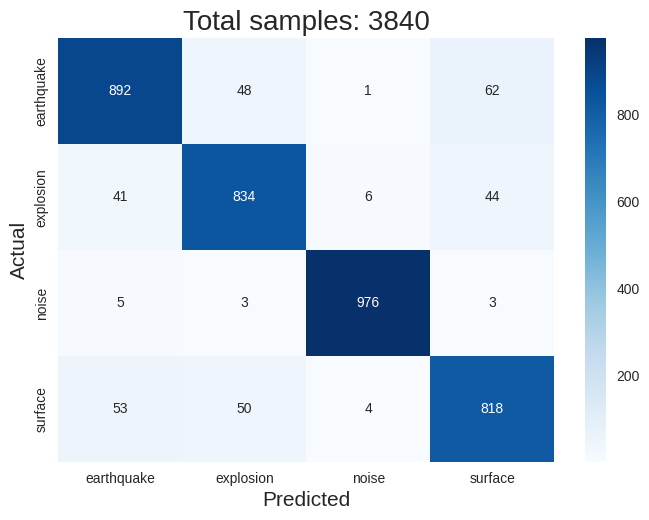

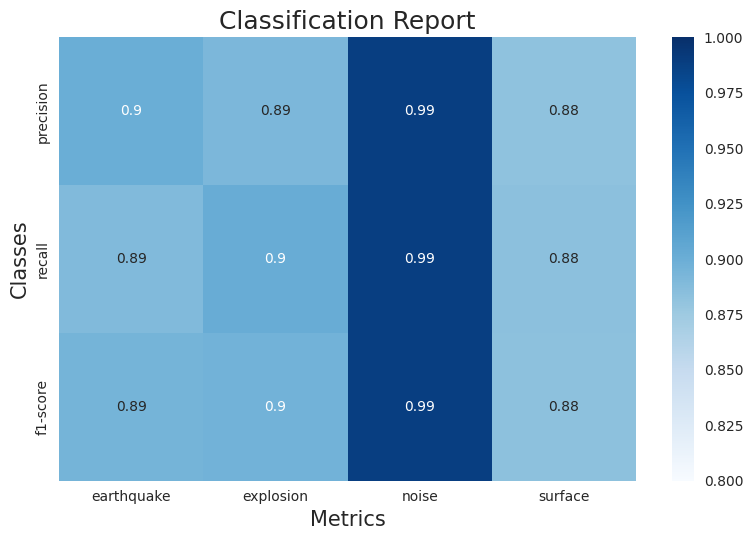

In [21]:
avg_cm_mycnn_2d = compute_average_model_performance(num_iter = 10, model_name = "model_mycnn_2d", one_d = False, d_su = d_su, d_eq = d_eq, d_exp = d_exp, d_noise = d_noise,
                                                         learning_rate = learning_rate, criterion = criterion)

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1424.37it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:35,  1.06s/it]

[Epoch 10] loss: 0.262 - accuracy: 84.375


 20%|██        | 20/100 [00:21<01:24,  1.05s/it]

[Epoch 20] loss: 0.147 - accuracy: 89.062


 30%|███       | 30/100 [00:31<01:13,  1.05s/it]

[Epoch 30] loss: 0.082 - accuracy: 87.500


 40%|████      | 40/100 [00:42<01:03,  1.05s/it]

[Epoch 40] loss: 0.060 - accuracy: 92.969


 50%|█████     | 50/100 [00:52<00:52,  1.05s/it]

[Epoch 50] loss: 0.048 - accuracy: 94.531


 60%|██████    | 60/100 [01:03<00:41,  1.05s/it]

[Epoch 60] loss: 0.046 - accuracy: 92.969


 70%|███████   | 70/100 [01:13<00:31,  1.05s/it]

[Epoch 70] loss: 0.049 - accuracy: 94.922


 77%|███████▋  | 77/100 [01:22<00:24,  1.07s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.227 and accuracy: 93.802
test loss: 0.228 and accuracy: 93.828


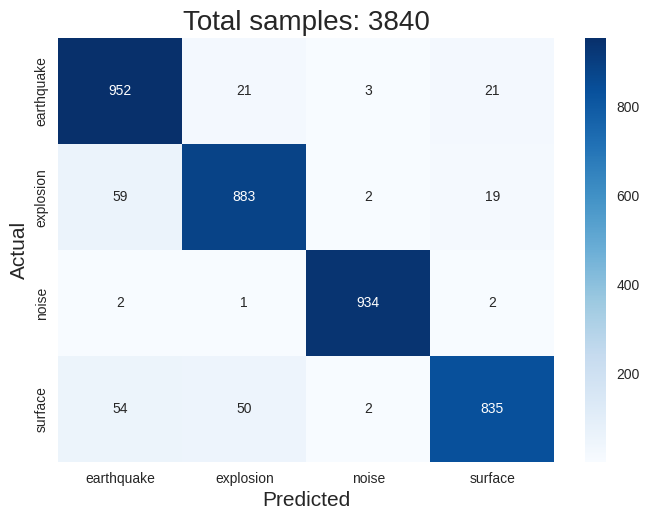

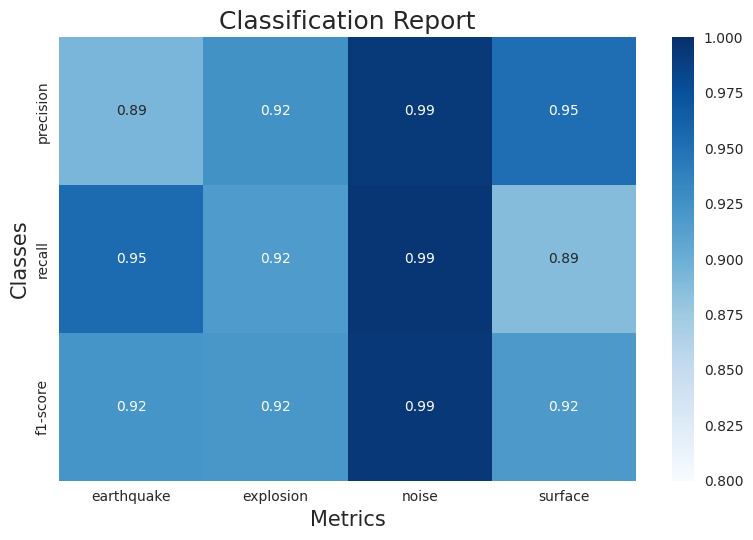

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1471.63it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:34,  1.05s/it]

[Epoch 10] loss: 0.249 - accuracy: 77.344


 20%|██        | 20/100 [00:21<01:23,  1.05s/it]

[Epoch 20] loss: 0.141 - accuracy: 89.844


 30%|███       | 30/100 [00:31<01:13,  1.05s/it]

[Epoch 30] loss: 0.088 - accuracy: 93.359


 40%|████      | 40/100 [00:42<01:02,  1.05s/it]

[Epoch 40] loss: 0.059 - accuracy: 88.281


 50%|█████     | 50/100 [00:52<00:52,  1.05s/it]

[Epoch 50] loss: 0.048 - accuracy: 93.750


 60%|██████    | 60/100 [01:03<00:41,  1.05s/it]

[Epoch 60] loss: 0.031 - accuracy: 93.359


 63%|██████▎   | 63/100 [01:07<00:39,  1.07s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.227 and accuracy: 93.646
test loss: 0.226 and accuracy: 93.620


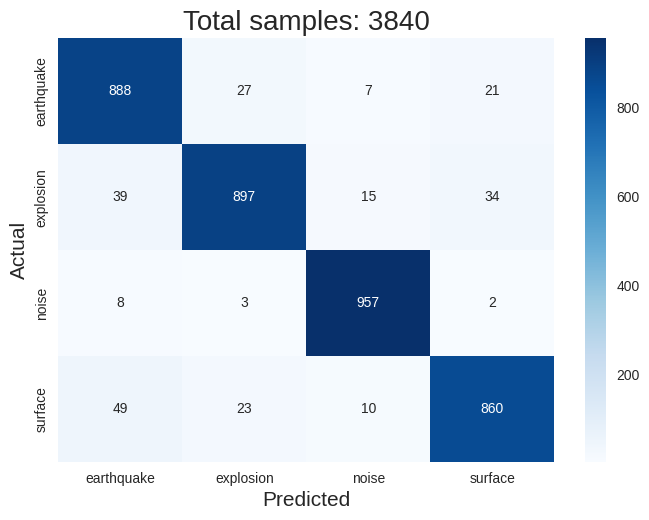

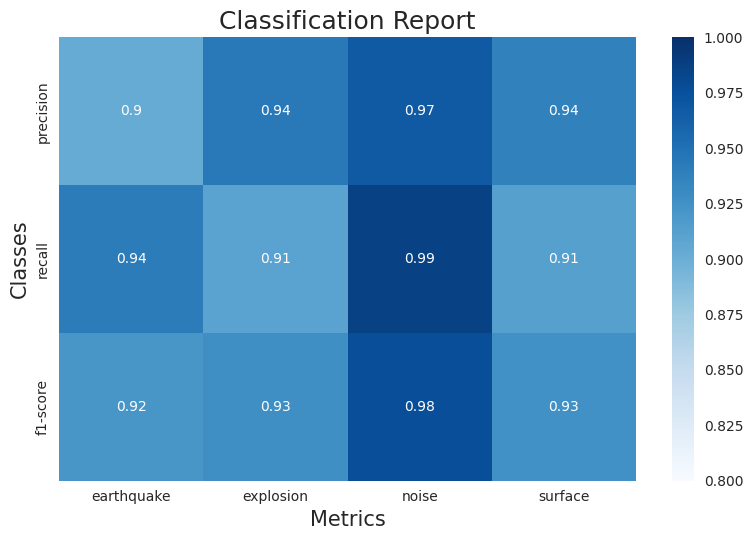

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1484.17it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:34,  1.05s/it]

[Epoch 10] loss: 0.248 - accuracy: 69.141


 20%|██        | 20/100 [00:20<01:23,  1.05s/it]

[Epoch 20] loss: 0.147 - accuracy: 92.578


 30%|███       | 30/100 [00:31<01:13,  1.05s/it]

[Epoch 30] loss: 0.094 - accuracy: 94.531


 40%|████      | 40/100 [00:41<01:02,  1.05s/it]

[Epoch 40] loss: 0.059 - accuracy: 94.141


 50%|█████     | 50/100 [00:52<00:52,  1.05s/it]

[Epoch 50] loss: 0.048 - accuracy: 94.141


 60%|██████    | 60/100 [01:02<00:41,  1.05s/it]

[Epoch 60] loss: 0.036 - accuracy: 94.531


 70%|███████   | 70/100 [01:13<00:31,  1.05s/it]

[Epoch 70] loss: 0.033 - accuracy: 94.922


 80%|████████  | 80/100 [01:23<00:20,  1.05s/it]

[Epoch 80] loss: 0.027 - accuracy: 94.531


 90%|█████████ | 90/100 [01:34<00:10,  1.05s/it]

[Epoch 90] loss: 0.026 - accuracy: 94.922


 93%|█████████▎| 93/100 [01:38<00:07,  1.06s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.281 and accuracy: 93.828
test loss: 0.282 and accuracy: 93.854


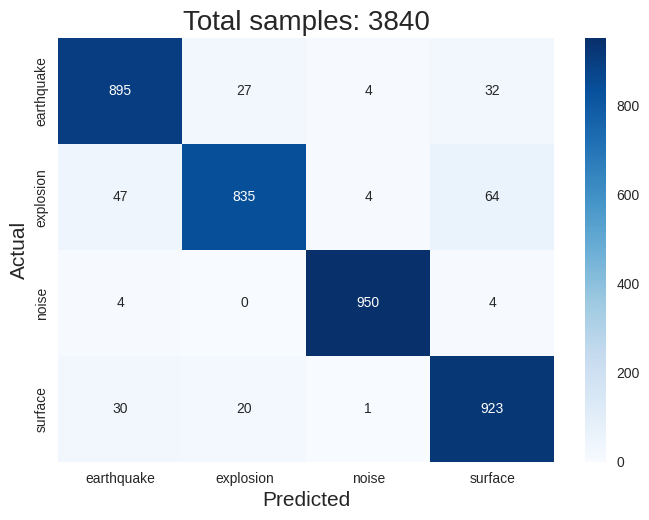

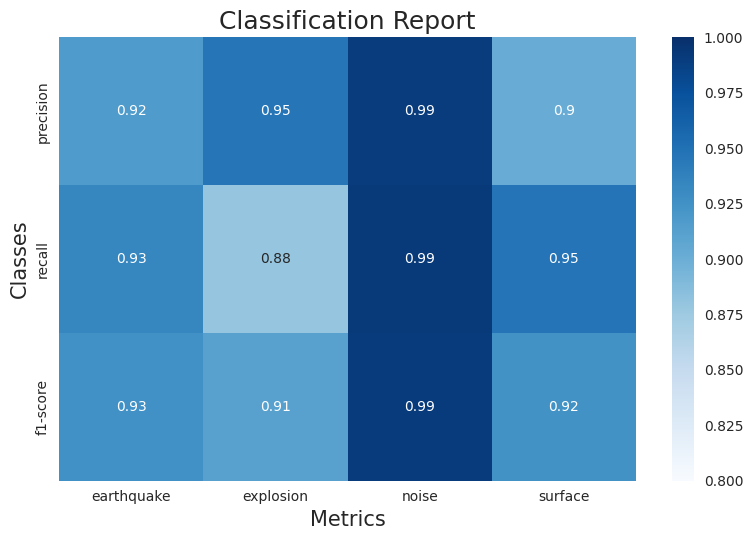

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1505.80it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:33,  1.04s/it]

[Epoch 10] loss: 0.250 - accuracy: 90.625


 20%|██        | 20/100 [00:20<01:23,  1.04s/it]

[Epoch 20] loss: 0.150 - accuracy: 88.672


 30%|███       | 30/100 [00:31<01:13,  1.04s/it]

[Epoch 30] loss: 0.091 - accuracy: 94.141


 40%|████      | 40/100 [00:41<01:02,  1.05s/it]

[Epoch 40] loss: 0.074 - accuracy: 86.719


 50%|█████     | 50/100 [00:52<00:52,  1.05s/it]

[Epoch 50] loss: 0.048 - accuracy: 91.016


 60%|██████    | 60/100 [01:02<00:41,  1.05s/it]

[Epoch 60] loss: 0.038 - accuracy: 93.359


 60%|██████    | 60/100 [01:03<00:42,  1.06s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.254 and accuracy: 92.630
test loss: 0.255 and accuracy: 92.604


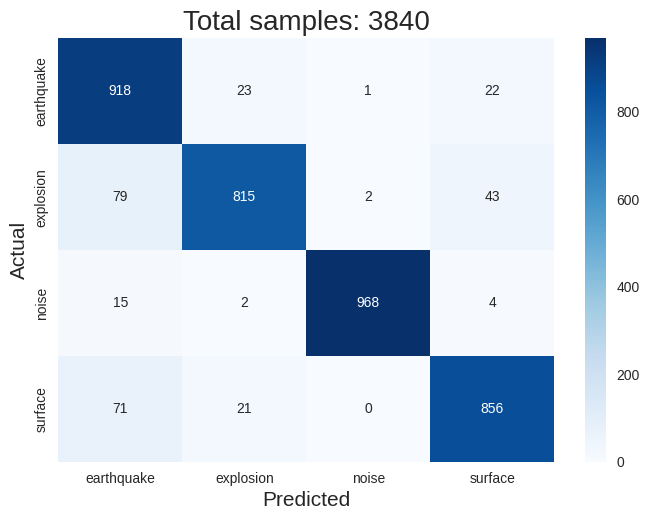

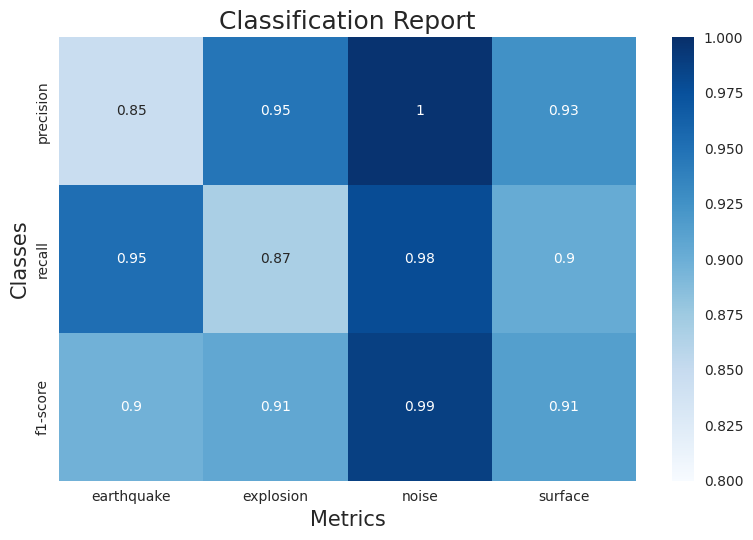

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1472.60it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:34,  1.05s/it]

[Epoch 10] loss: 0.246 - accuracy: 90.234


 20%|██        | 20/100 [00:20<01:23,  1.04s/it]

[Epoch 20] loss: 0.143 - accuracy: 87.500


 30%|███       | 30/100 [00:31<01:13,  1.04s/it]

[Epoch 30] loss: 0.088 - accuracy: 92.969


 40%|████      | 40/100 [00:41<01:02,  1.04s/it]

[Epoch 40] loss: 0.057 - accuracy: 88.672


 50%|█████     | 50/100 [00:52<00:52,  1.04s/it]

[Epoch 50] loss: 0.050 - accuracy: 93.750


 56%|█████▌    | 56/100 [00:59<00:46,  1.06s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.231 and accuracy: 93.568
test loss: 0.228 and accuracy: 93.542


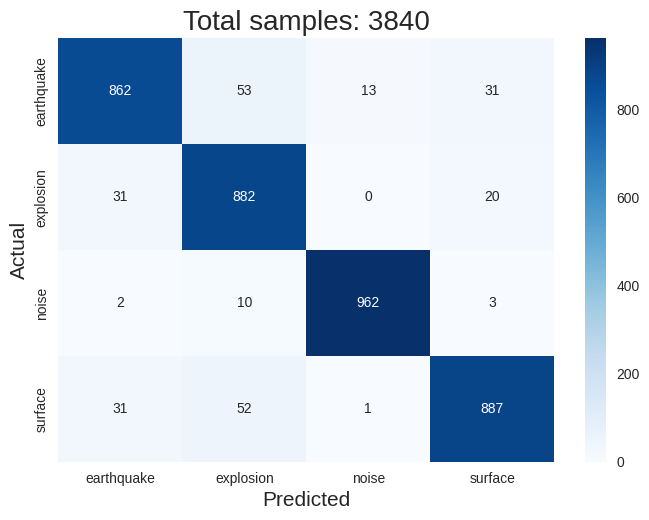

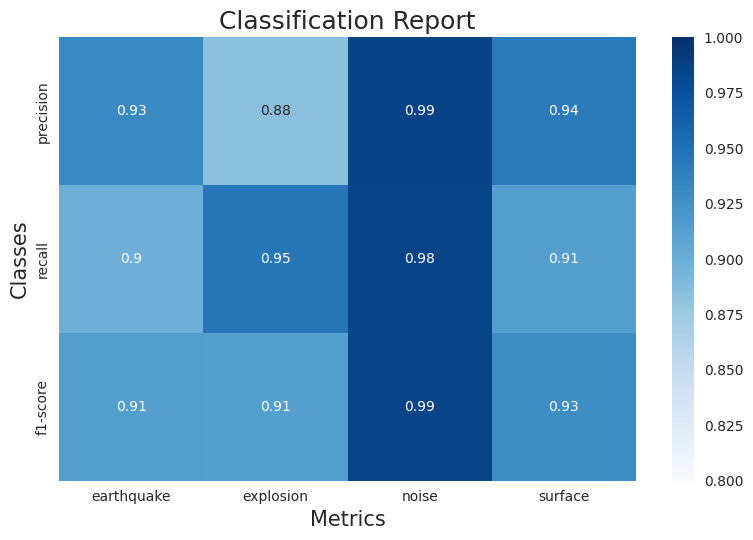

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1509.93it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:34,  1.05s/it]

[Epoch 10] loss: 0.261 - accuracy: 91.016


 20%|██        | 20/100 [00:20<01:23,  1.05s/it]

[Epoch 20] loss: 0.150 - accuracy: 89.062


 30%|███       | 30/100 [00:31<01:13,  1.05s/it]

[Epoch 30] loss: 0.082 - accuracy: 93.359


 40%|████      | 40/100 [00:41<01:02,  1.04s/it]

[Epoch 40] loss: 0.058 - accuracy: 91.797


 50%|█████     | 50/100 [00:52<00:52,  1.05s/it]

[Epoch 50] loss: 0.051 - accuracy: 91.406


 60%|██████    | 60/100 [01:02<00:41,  1.04s/it]

[Epoch 60] loss: 0.033 - accuracy: 94.531


 63%|██████▎   | 63/100 [01:06<00:39,  1.06s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.186 and accuracy: 94.323
test loss: 0.184 and accuracy: 94.349


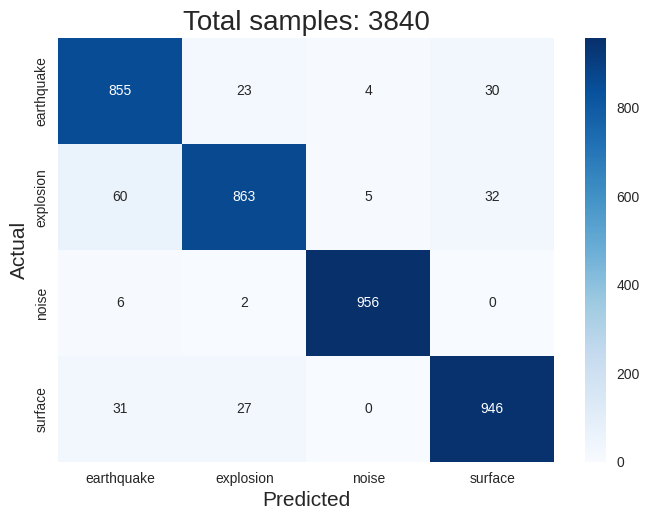

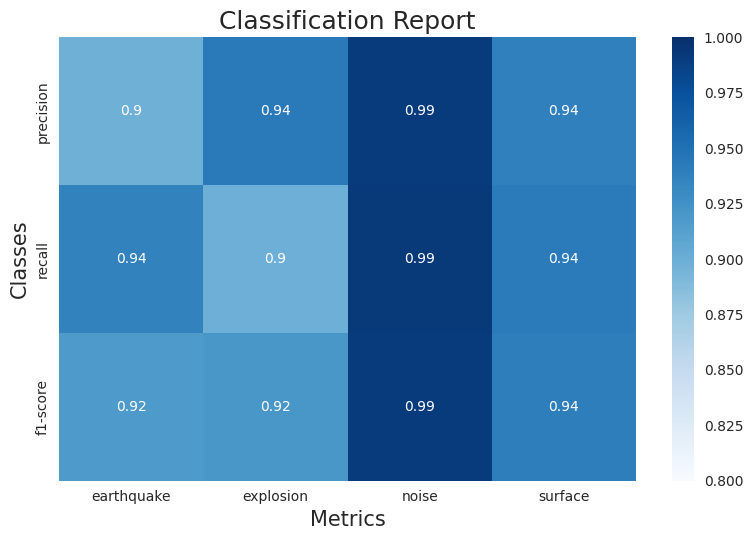

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1505.96it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:33,  1.04s/it]

[Epoch 10] loss: 0.282 - accuracy: 73.047


 20%|██        | 20/100 [00:20<01:23,  1.04s/it]

[Epoch 20] loss: 0.155 - accuracy: 82.812


 30%|███       | 30/100 [00:31<01:13,  1.05s/it]

[Epoch 30] loss: 0.092 - accuracy: 89.062


 40%|████      | 40/100 [00:41<01:02,  1.05s/it]

[Epoch 40] loss: 0.060 - accuracy: 92.969


 50%|█████     | 50/100 [00:52<00:52,  1.05s/it]

[Epoch 50] loss: 0.048 - accuracy: 94.531


 60%|██████    | 60/100 [01:02<00:41,  1.05s/it]

[Epoch 60] loss: 0.037 - accuracy: 92.188


 70%|███████   | 70/100 [01:13<00:31,  1.05s/it]

[Epoch 70] loss: 0.038 - accuracy: 91.406


 80%|████████  | 80/100 [01:23<00:20,  1.05s/it]

[Epoch 80] loss: 0.025 - accuracy: 94.141


 82%|████████▏ | 82/100 [01:26<00:19,  1.06s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.246 and accuracy: 93.776
test loss: 0.246 and accuracy: 93.724


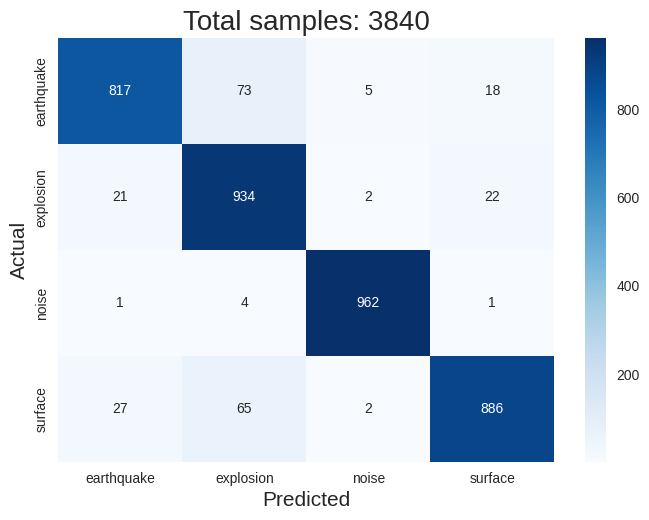

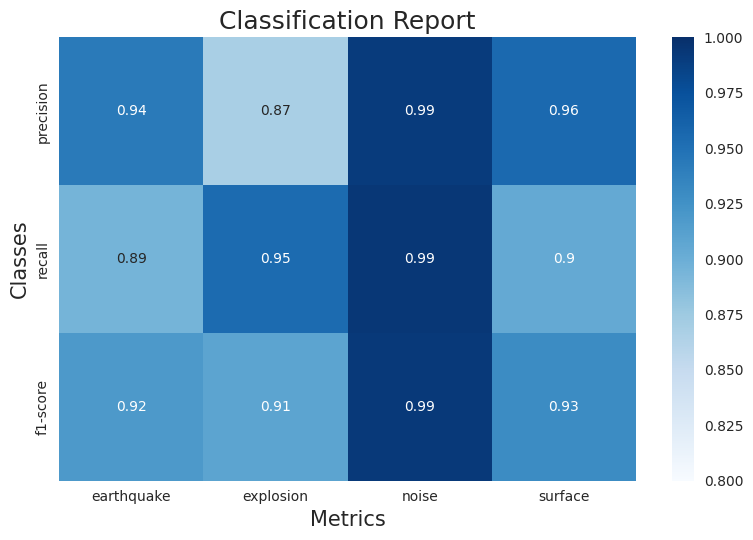

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1452.15it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:35,  1.06s/it]

[Epoch 10] loss: 0.269 - accuracy: 87.500


 20%|██        | 20/100 [00:21<01:24,  1.06s/it]

[Epoch 20] loss: 0.156 - accuracy: 91.797


 30%|███       | 30/100 [00:31<01:14,  1.06s/it]

[Epoch 30] loss: 0.096 - accuracy: 83.984


 40%|████      | 40/100 [00:42<01:03,  1.06s/it]

[Epoch 40] loss: 0.065 - accuracy: 89.844


 50%|█████     | 50/100 [00:52<00:52,  1.06s/it]

[Epoch 50] loss: 0.051 - accuracy: 92.188


 60%|██████    | 60/100 [01:03<00:42,  1.05s/it]

[Epoch 60] loss: 0.042 - accuracy: 92.969


 70%|███████   | 70/100 [01:14<00:31,  1.06s/it]

[Epoch 70] loss: 0.036 - accuracy: 93.750


 71%|███████   | 71/100 [01:16<00:31,  1.07s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.261 and accuracy: 93.151
test loss: 0.258 and accuracy: 93.203


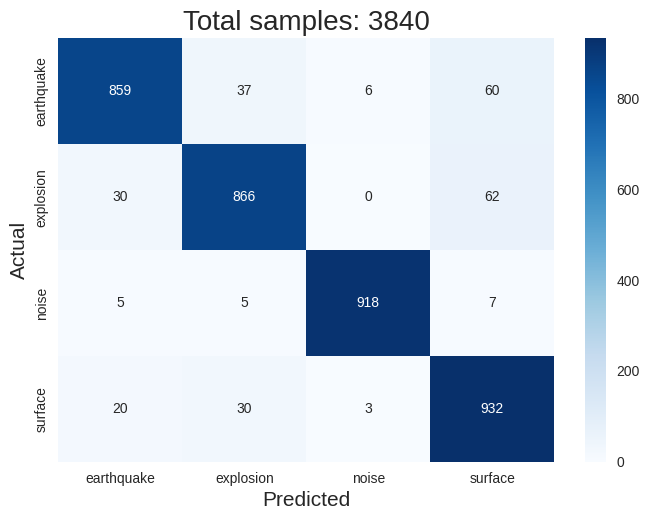

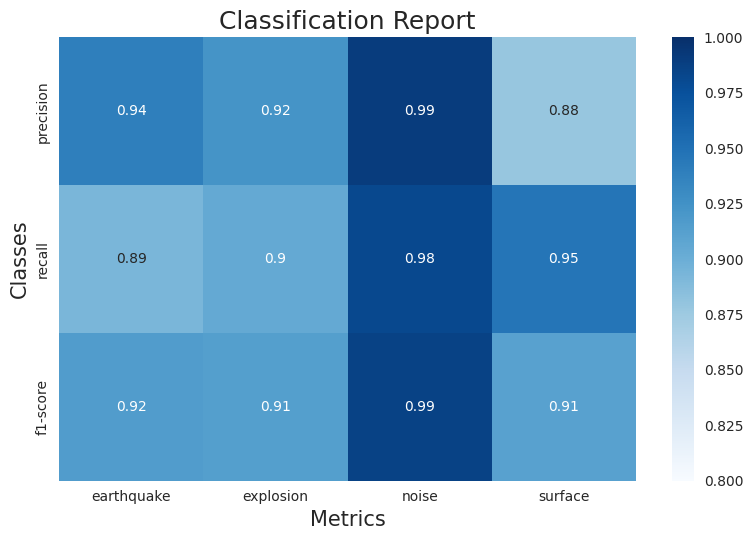

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1458.23it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:35,  1.06s/it]

[Epoch 10] loss: 0.254 - accuracy: 87.109


 20%|██        | 20/100 [00:21<01:24,  1.06s/it]

[Epoch 20] loss: 0.142 - accuracy: 91.016


 30%|███       | 30/100 [00:31<01:14,  1.06s/it]

[Epoch 30] loss: 0.096 - accuracy: 89.062


 40%|████      | 40/100 [00:42<01:03,  1.05s/it]

[Epoch 40] loss: 0.056 - accuracy: 91.797


 50%|█████     | 50/100 [00:52<00:52,  1.06s/it]

[Epoch 50] loss: 0.042 - accuracy: 94.922


 58%|█████▊    | 58/100 [01:02<00:45,  1.07s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.215 and accuracy: 93.646
test loss: 0.212 and accuracy: 93.724


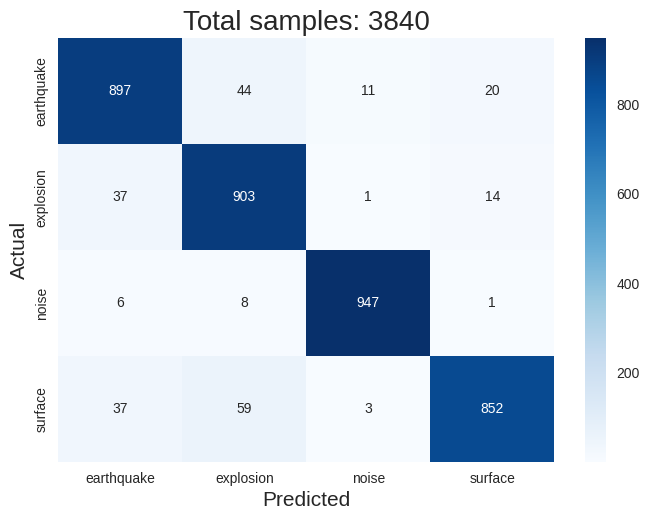

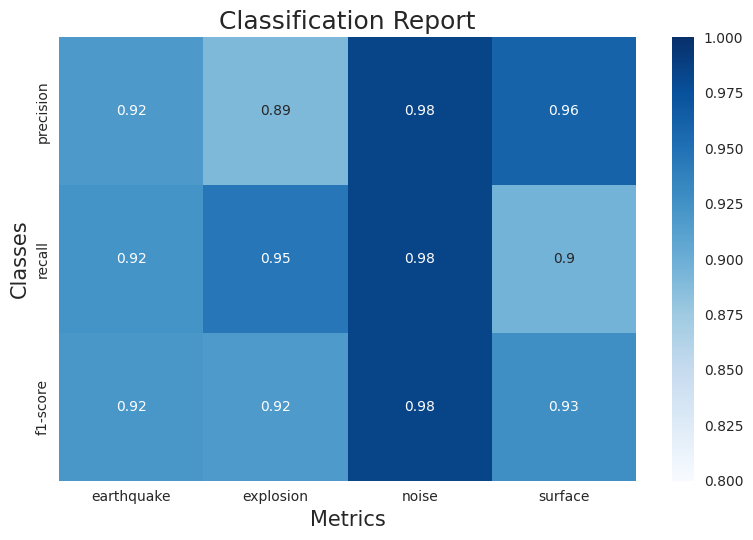

  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


  0%|          | 0/3500 [00:00<?, ?it/s]

(3500, 3, 129, 38)


100%|██████████| 3500/3500 [00:02<00:00, 1464.15it/s]


(3500, 3, 129, 38)


  0%|          | 0/100 [00:00<?, ?it/s]

76 2 30
76 2 30


 10%|█         | 10/100 [00:10<01:35,  1.06s/it]

[Epoch 10] loss: 0.264 - accuracy: 82.031


 20%|██        | 20/100 [00:21<01:24,  1.06s/it]

[Epoch 20] loss: 0.148 - accuracy: 86.328


 30%|███       | 30/100 [00:31<01:13,  1.06s/it]

[Epoch 30] loss: 0.094 - accuracy: 91.406


 40%|████      | 40/100 [00:42<01:03,  1.06s/it]

[Epoch 40] loss: 0.064 - accuracy: 90.234


 50%|█████     | 50/100 [00:52<00:52,  1.06s/it]

[Epoch 50] loss: 0.043 - accuracy: 92.578


 57%|█████▋    | 57/100 [01:01<00:46,  1.07s/it]
/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

test loss: 0.213 and accuracy: 93.281
test loss: 0.215 and accuracy: 93.359


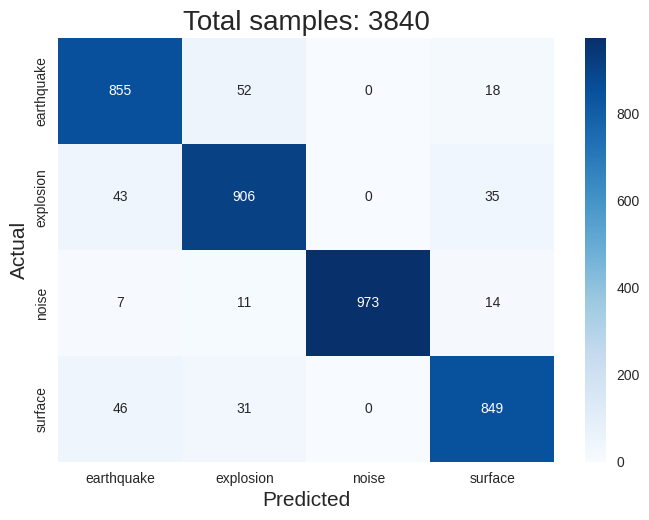

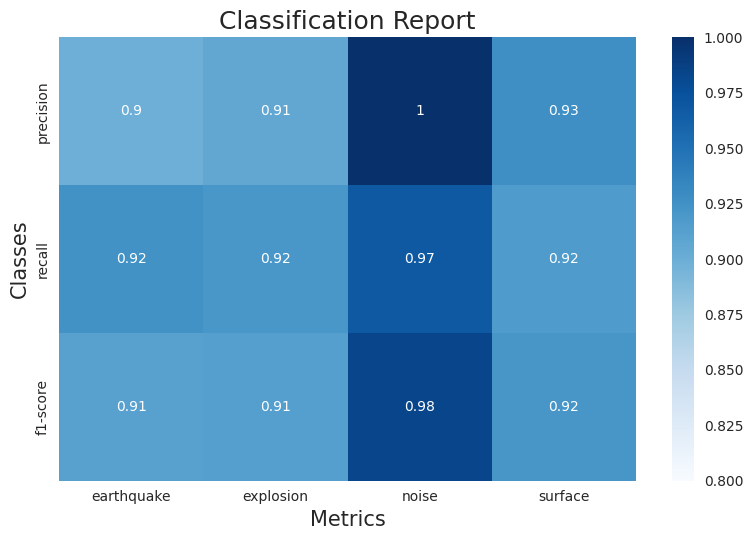

In [22]:
avg_cm_myrescnn_2d = compute_average_model_performance(num_iter = 10, model_name = "model_myrescnn_2d", one_d = False, d_su = d_su, d_eq = d_eq, d_exp = d_exp, d_noise = d_noise,
                                                         learning_rate = learning_rate, criterion = criterion)

## Computing the mean Confusion Matrix and Classification Report

In [23]:
mean_cm_seismiccnn_2d = np.mean(avg_cm_seismiccnn_2d, axis = 0)
mean_cm_mycnn_2d = np.mean(avg_cm_mycnn_2d, axis = 0)
mean_cm_myrescnn_2d = np.mean(avg_cm_myrescnn_2d, axis = 0)
mean_cm_mycnn_1d = np.mean(avg_cm_mycnn_1d, axis = 0)

In [24]:
def generate_cr(cm = mean_cm_seismiccnn_2d):
    import numpy as np
    import seaborn as sns
    from sklearn.metrics import classification_report

    # Confusion matrix (rounded to nearest integer)
    cm = cm.astype('int')
    # Total number of samples
    total_samples = cm.sum()

    # True labels based on the confusion matrix
    y_true = np.repeat([0, 1, 2, 3], cm.sum(axis=1))

    # Predicted labels based on the confusion matrix
    y_pred = np.hstack([[i] * cm[j, i] for j in range(4) for i in range(4)])

    # Class labels
    labels = ['Earthquake', 'Explosion', 'Noise', 'Surface Event']

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    
    plt.figure()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels = labels, yticklabels = labels)
    
    plt.figure()
    sns.heatmap(pd.DataFrame(report).iloc[:3, :4], annot=True, cmap='Blues', xticklabels= labels, vmin=0.8, vmax=1)
    return report


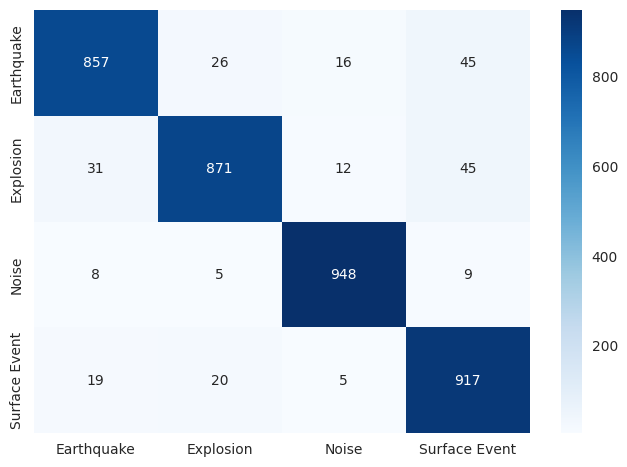

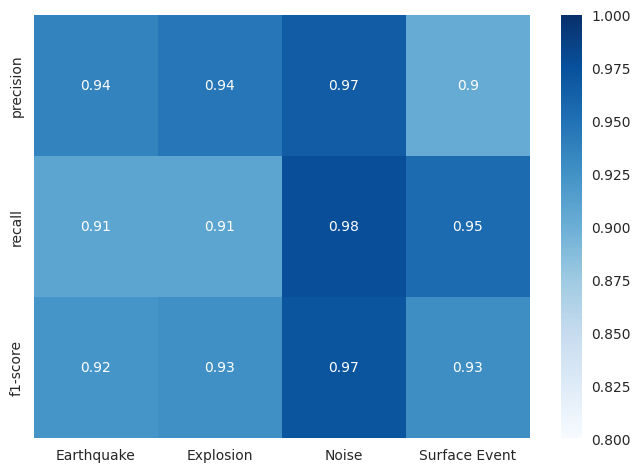

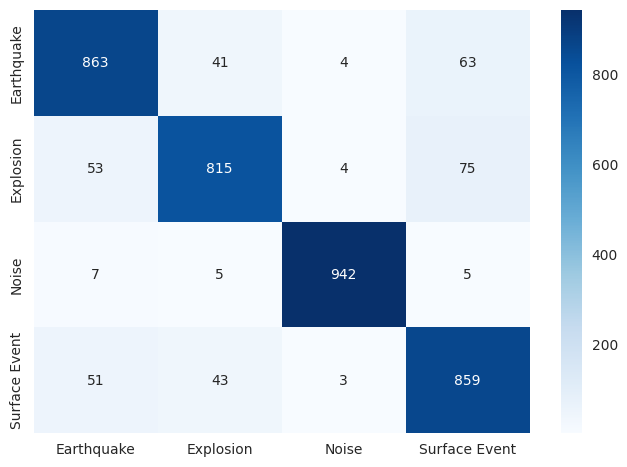

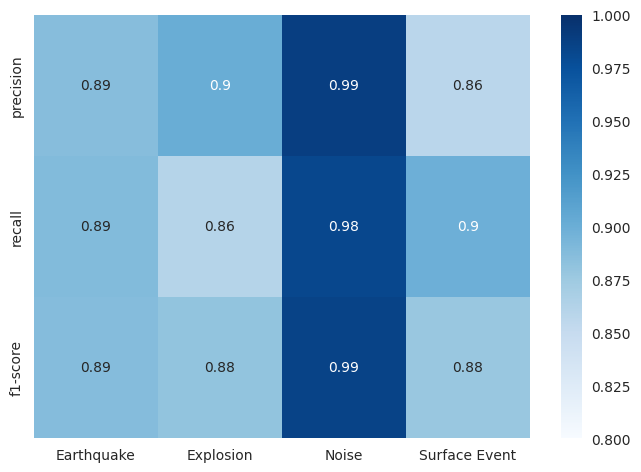

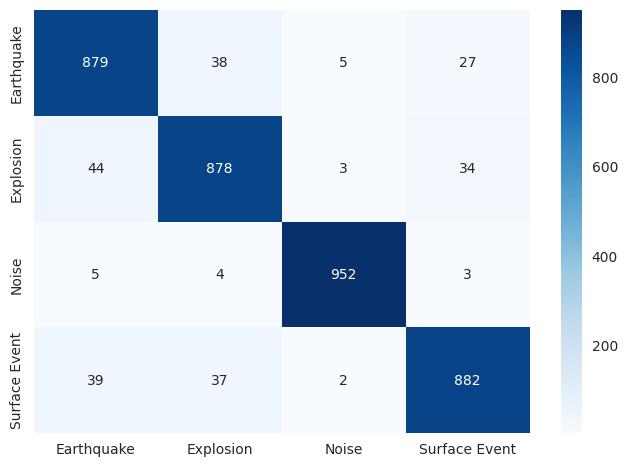

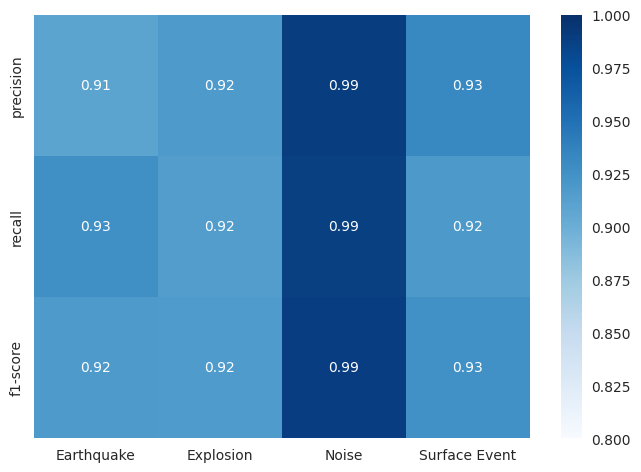

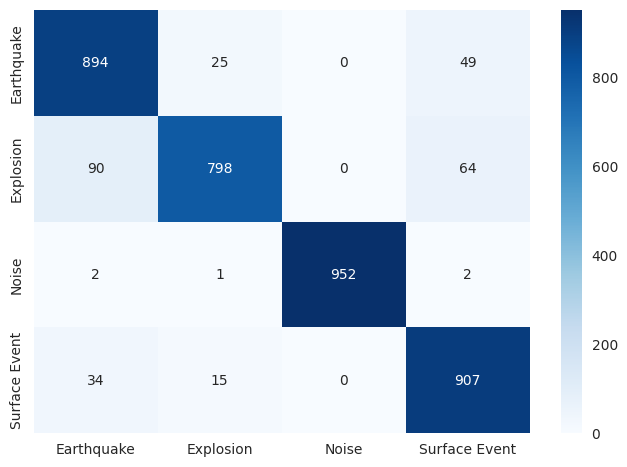

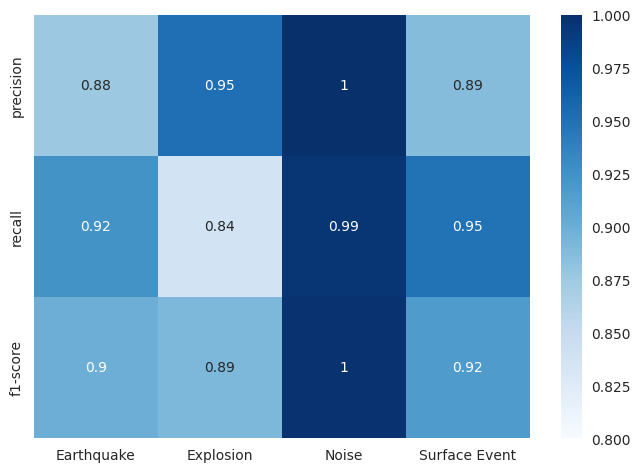

In [26]:
final_report_seismiccnn_2d = generate_cr(mean_cm_seismiccnn_2d)
final_report_mycnn_2d = generate_cr(mean_cm_mycnn_2d)
final_report_myrescnn_2d = generate_cr(mean_cm_myrescnn_2d)
final_report_mycnn_1d = generate_cr(mean_cm_mycnn_1d)

## Saving the results on the balanced number of traces

In [27]:
import pickle
# saving balanced trace wise report    
with open('../results/balanced_trace_report_deep_learning_mycnn_1d.pkl', 'wb') as pickle_file:
        pickle.dump(final_report_mycnn_1d, pickle_file)
        
# saving balanced trace wise report    
with open('../results/balanced_trace_report_deep_learning_mycnn_2d.pkl', 'wb') as pickle_file:
        pickle.dump(final_report_mycnn_2d, pickle_file)

# saving balanced trace wise report    
with open('../results/balanced_trace_report_deep_learning_seismiccnn_2d.pkl', 'wb') as pickle_file:
        pickle.dump(final_report_seismiccnn_2d, pickle_file)

# saving balanced trace wise report    
with open('../results/balanced_trace_report_deep_learning_myrescnn_2d.pkl', 'wb') as pickle_file:
        pickle.dump(final_report_myrescnn_2d, pickle_file)


        



# saving balanced trace wise confusion matrix. 
with open('../results/balanced_trace_confusion_matrix_deep_learning_mycnn_1d.pkl', 'wb') as pickle_file:
        pickle.dump(mean_cm_mycnn_1d, pickle_file)
        
# saving balanced trace wise confusion matrix. 
with open('../results/balanced_trace_confusion_matrix_deep_learning_mycnn_2d.pkl', 'wb') as pickle_file:
        pickle.dump(mean_cm_mycnn_2d, pickle_file)

# saving balanced trace wise confusion matrix. 
with open('../results/balanced_trace_confusion_matrix_deep_learning_myseismiccnn_2d.pkl', 'wb') as pickle_file:
        pickle.dump(mean_cm_seismiccnn_2d, pickle_file)
        
# saving balanced trace wise confusion matrix. 
with open('../results/balanced_trace_confusion_matrix_deep_learning_myrescnn_2d.pkl', 'wb') as pickle_file:
        pickle.dump(mean_cm_myrescnn_2d, pickle_file)
